In [1]:
from lib.data_preprocess import load_data

data_file = r"C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat"
seq_len = 256

ori_data, scalers, feature_names = load_data(
    "mytests",
    seq_len,
    file_list=[data_file],
    step=128,
    max_sequences=50000
)

print(len(ori_data), ori_data[0].shape)
print("Features:", feature_names)
print("N scalers:", len(scalers))



📌 Loading: C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat
📌 Feature order: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
📌 Total sequences: 50000 | Each: 256×7
50000 (256, 7)
Features: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
N scalers: 24


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

mat_path = r"C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat"

print(" ANALYSIS OF all_signals_processed.mat\n")

with h5py.File(mat_path, "r") as f:

    data_all = f["data_all"]
    n_files = data_all.shape[1]

    print(f" Total JSON files inside: {n_files}")

    signal_lengths = []
    file_lengths = []
    signal_names_global = None

    for i in range(n_files):
        ref = data_all[0][i]
        entry = f[ref]

        sig_group = entry["signals_processed"]
        sig_names = list(sig_group.keys())

        # Save signal names from first file
        if signal_names_global is None:
            signal_names_global = sig_names

        # Read one signal just to know length
        first_signal = np.array(sig_group[sig_names[0]][:]).flatten()
        file_lengths.append(len(first_signal))

        signal_lengths.append([len(np.array(sig_group[s])[:].flatten())
                               for s in sig_names])

    signal_lengths = np.array(signal_lengths)

    print("\n Signals available:", signal_names_global)
    print(" Number of signals:", len(signal_names_global))

    print("\n Length statistics per file (all signals have same length inside a file):")
    print(f"   Min length: {signal_lengths.min()}")
    print(f"   Max length: {signal_lengths.max()}")
  

    print("\n Total samples (sum of lengths):",
          int(signal_lengths[:, 0].sum()))



 ANALYSIS OF all_signals_processed.mat

 Total JSON files inside: 204

 Signals available: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
 Number of signals: 7

 Length statistics per file (all signals have same length inside a file):
   Min length: 270000
   Max length: 270000

 Total samples (sum of lengths): 55080000


In [7]:

from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# 1. Options
opt = Options().parse()


opt.print_freq = 100    # imprime cada iteración

# 2. Set paper-style hyperparameters
opt.lr_g = 1e-4     # LR para el generador
opt.lr_d = 5e-4    # LR para el discriminador
opt.lr_e = 1e-3     # encoder
opt.lr_r = 1e-3     # recovery
opt.lr_s = 1e-3     # supervisor


opt.beta1 = 0.5

opt.batch_size = 64
opt.iteration = 500

opt.hidden_dim = 32   # muy importante
opt.num_layer = 4

opt.n_critic = 5      # OK
opt.gp_lambda = 10   # OK
opt.name = "TimeGAN_real_paper_settings"

opt.w_g    = 1.0   # antes 80
opt.w_e0   = 1.0   # antes 10
opt.w_es   = 1.0   # antes 0.1, lo dejamos en la misma escala
opt.w_gamma = 1.0  # este se puede mantener


# 3. Create model
model = TimeGAN(opt, ori_data)

# 4. Train
model.train()


[INFO] Adjusted opt.z_dim to match data feature size: 7
=== PRETRAINING: Embedding + Recovery ===
[DEBUG] Loss this iteration: 0.101021
[ER] Iter 0/500 | ER Loss = 0.101021
[DEBUG] Loss this iteration: 0.066123
[DEBUG] Loss this iteration: 0.043949
[DEBUG] Loss this iteration: 0.027737
[DEBUG] Loss this iteration: 0.020657
[DEBUG] Loss this iteration: 0.015910
[DEBUG] Loss this iteration: 0.017436
[DEBUG] Loss this iteration: 0.014999
[DEBUG] Loss this iteration: 0.012766
[DEBUG] Loss this iteration: 0.014178
[DEBUG] Loss this iteration: 0.010221
[DEBUG] Loss this iteration: 0.008395
[DEBUG] Loss this iteration: 0.008508
[DEBUG] Loss this iteration: 0.007857
[DEBUG] Loss this iteration: 0.008628
[DEBUG] Loss this iteration: 0.007084
[DEBUG] Loss this iteration: 0.006113
[DEBUG] Loss this iteration: 0.004932
[DEBUG] Loss this iteration: 0.005260
[DEBUG] Loss this iteration: 0.004794
[DEBUG] Loss this iteration: 0.004318
[DEBUG] Loss this iteration: 0.004113
[DEBUG] Loss this iteration: 

🧩 Generating 50 samples in 1 batches of 64...
  ✅ Batch 1/1 generated (50 samples)


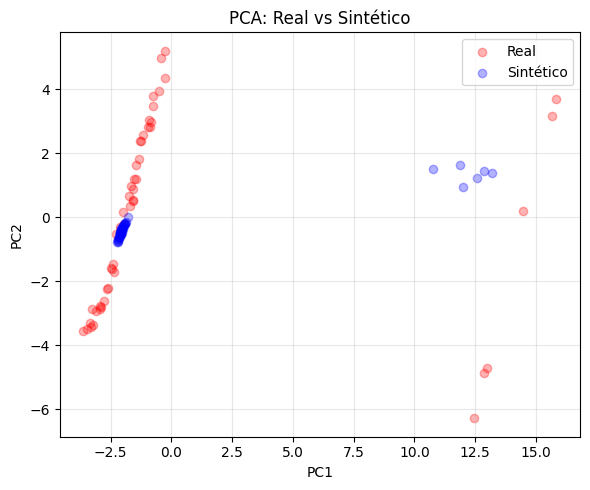

🌀 Ejecutando t-SNE (puede tardar unos segundos)...
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.534282
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.030140


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 500 iterations: 0.053610


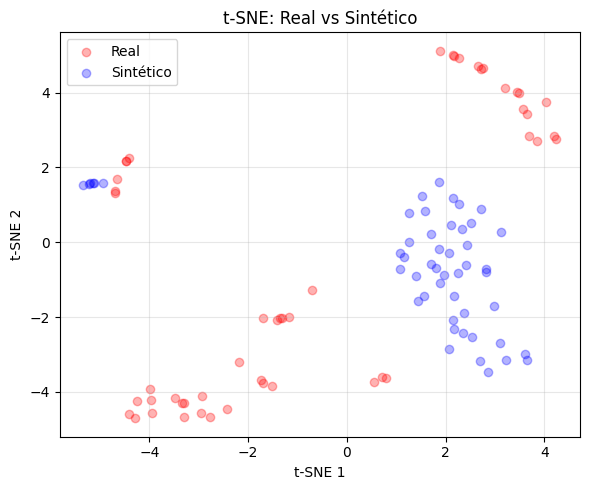

In [8]:
from generation_TGAN import safe_generation
import numpy as np

generated_data = safe_generation(model, num_samples=50, batch_size=64)

n_vis = 5000  # target

n_real = min(n_vis, len(ori_data))
n_fake = min(n_vis, len(generated_data))

idx_real = np.random.choice(len(ori_data), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

ori_vis = [ori_data[i] for i in idx_real]
gen_vis = [generated_data[i] for i in idx_fake]

from visualization_TGAN import visualization

visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')

In [ ]:

from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# 1. Options
opt = Options().parse()


opt.print_freq = 100    # imprime cada iteración

# 2. Set paper-style hyperparameters
opt.lr_g = 5e-5     # LR para el generador
opt.lr_d = 1e-4    # LR para el discriminador
opt.lr_e = 1e-4     # encoder
opt.lr_r = 5e-4     # recovery
opt.lr_s = 2e-4     # supervisor


opt.beta1 = 0.5

opt.batch_size = 64
opt.iteration = 500

opt.hidden_dim = 48   # muy importante
opt.num_layer = 2

opt.n_critic = 5     # OK
opt.gp_lambda = 10   # OK
opt.name = "TimeGAN_real_paper_settings"

opt.w_g    = 2.0   # antes 80
opt.w_e0   = 10.0   # antes 10
opt.w_es   = 1.0   # antes 0.1, lo dejamos en la misma escala
opt.w_gamma = 1.0  # este se puede mantener


# 3. Create model
model = TimeGAN(opt, ori_data)

# 4. Train
model.train()


[INFO] Auto-set z_dim = 7 (feature size from data)
=== PRETRAINING: Embedding + Recovery ===
[DEBUG] Loss this iteration: 0.104666
[ER] Iter 0/500 | ER Loss = 0.104666
[DEBUG] Loss this iteration: 0.088066
[DEBUG] Loss this iteration: 0.079391
[DEBUG] Loss this iteration: 0.062557
[DEBUG] Loss this iteration: 0.055545
[DEBUG] Loss this iteration: 0.051269
[DEBUG] Loss this iteration: 0.043463
[DEBUG] Loss this iteration: 0.044311
[DEBUG] Loss this iteration: 0.039465
[DEBUG] Loss this iteration: 0.035182
[DEBUG] Loss this iteration: 0.035176
[DEBUG] Loss this iteration: 0.036080
[DEBUG] Loss this iteration: 0.033907
[DEBUG] Loss this iteration: 0.031918
[DEBUG] Loss this iteration: 0.031632
[DEBUG] Loss this iteration: 0.029542
[DEBUG] Loss this iteration: 0.029894
[DEBUG] Loss this iteration: 0.026334
[DEBUG] Loss this iteration: 0.028177
[DEBUG] Loss this iteration: 0.024889
[DEBUG] Loss this iteration: 0.023683
[DEBUG] Loss this iteration: 0.024857
[DEBUG] Loss this iteration: 0.023

🧩 Generating 50000 samples in 782 batches of 64...
  ✅ Batch 1/782 generated (64 samples)
  ✅ Batch 2/782 generated (64 samples)
  ✅ Batch 3/782 generated (64 samples)
  ✅ Batch 4/782 generated (64 samples)
  ✅ Batch 5/782 generated (64 samples)
  ✅ Batch 6/782 generated (64 samples)
  ✅ Batch 7/782 generated (64 samples)
  ✅ Batch 8/782 generated (64 samples)
  ✅ Batch 9/782 generated (64 samples)
  ✅ Batch 10/782 generated (64 samples)
  ✅ Batch 11/782 generated (64 samples)
  ✅ Batch 12/782 generated (64 samples)
  ✅ Batch 13/782 generated (64 samples)
  ✅ Batch 14/782 generated (64 samples)
  ✅ Batch 15/782 generated (64 samples)
  ✅ Batch 16/782 generated (64 samples)
  ✅ Batch 17/782 generated (64 samples)
  ✅ Batch 18/782 generated (64 samples)
  ✅ Batch 19/782 generated (64 samples)
  ✅ Batch 20/782 generated (64 samples)
  ✅ Batch 21/782 generated (64 samples)
  ✅ Batch 22/782 generated (64 samples)
  ✅ Batch 23/782 generated (64 samples)
  ✅ Batch 24/782 generated (64 samples

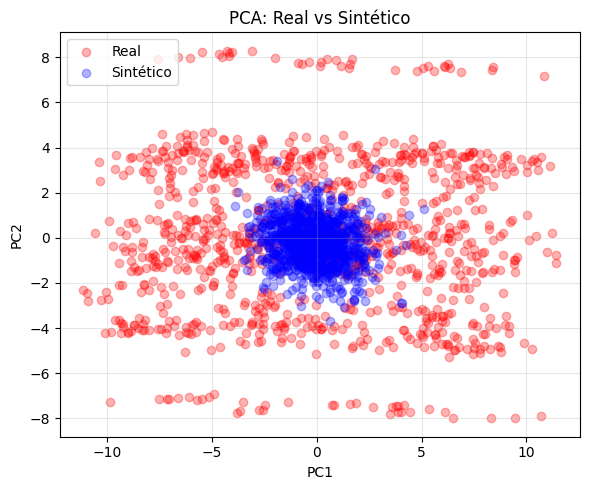

🌀 Ejecutando t-SNE (puede tardar unos segundos)...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.121s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.278545


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.169937
[t-SNE] KL divergence after 500 iterations: 1.967948


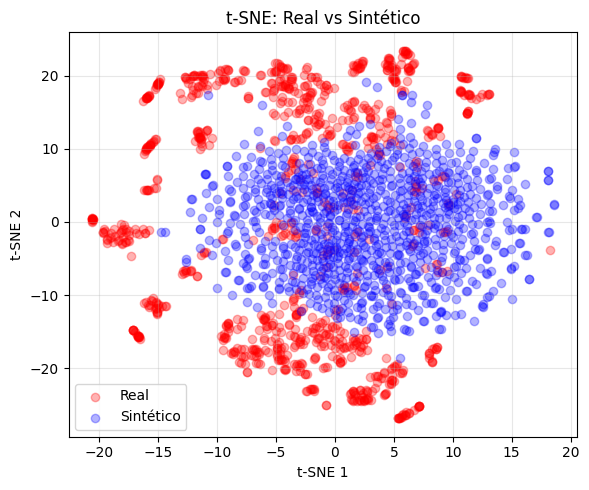

In [30]:
from generation_TGAN import safe_generation
import numpy as np

generated_data = safe_generation(model, num_samples=len(ori_data), batch_size=64)

n_vis = 50000  # target

n_real = min(n_vis, len(ori_data))
n_fake = min(n_vis, len(generated_data))

idx_real = np.random.choice(len(ori_data), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

ori_vis = [ori_data[i] for i in idx_real]
gen_vis = [generated_data[i] for i in idx_fake]

from visualization_TGAN import visualization

visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')

In [31]:
import numpy as np

syn_data = np.array(generated_data)   # datos sintéticos
real_data = np.array(ori_data)        # datos reales

# Aplanar correctamente: (N, seq_len, features)
# Calculamos medias y std por feature
real_mean = real_data.mean(axis=(0,1))
real_std  = real_data.std(axis=(0,1))

syn_mean  = syn_data.mean(axis=(0,1))
syn_std   = syn_data.std(axis=(0,1))

print("==== MEDIA POR FEATURE ====")
for i in range(len(real_mean)):
    print(f"Feature {i}: Real = {real_mean[i]:.4f}, Synthetic = {syn_mean[i]:.4f}")

print("\n==== STD POR FEATURE ====")
for i in range(len(real_std)):
    print(f"Feature {i}: Real = {real_std[i]:.4f}, Synthetic = {syn_std[i]:.4f}")


==== MEDIA POR FEATURE ====
Feature 0: Real = 0.5047, Synthetic = 0.5004
Feature 1: Real = 0.4585, Synthetic = 0.4532
Feature 2: Real = 0.4708, Synthetic = 0.4627
Feature 3: Real = 0.4982, Synthetic = 0.4953
Feature 4: Real = 0.5024, Synthetic = 0.4856
Feature 5: Real = 0.5642, Synthetic = 0.5555
Feature 6: Real = 0.4427, Synthetic = 0.4196

==== STD POR FEATURE ====
Feature 0: Real = 0.2008, Synthetic = 0.1991
Feature 1: Real = 0.1775, Synthetic = 0.1675
Feature 2: Real = 0.1453, Synthetic = 0.1422
Feature 3: Real = 0.2195, Synthetic = 0.2129
Feature 4: Real = 0.1735, Synthetic = 0.1676
Feature 5: Real = 0.1822, Synthetic = 0.1767
Feature 6: Real = 0.2921, Synthetic = 0.2793


In [32]:

from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# 1. Options
opt = Options().parse()


opt.print_freq = 100    # imprime cada iteración

# 2. Set paper-style hyperparameters
opt.lr_g = 5e-5     # LR para el generador
opt.lr_d = 1e-4    # LR para el discriminador
opt.lr_e = 1e-4     # encoder
opt.lr_r = 5e-4     # recovery
opt.lr_s = 2e-4     # supervisor


opt.beta1 = 0.5

opt.batch_size = 64
opt.iteration = 500

opt.hidden_dim = 48   # muy importante
opt.num_layer = 2

opt.n_critic = 7     # OK
opt.gp_lambda = 10   # OK
opt.name = "TimeGAN_real_paper_settings"

opt.w_g    = 2.0   # antes 80
opt.w_e0   = 10.0   # antes 10
opt.w_es   = 0.5   # antes 0.1, lo dejamos en la misma escala
opt.w_gamma = 1.0  # este se puede mantener


# 3. Create model
model = TimeGAN(opt, ori_data)

# 4. Train
model.train()


[INFO] Auto-set z_dim = 7 (feature size from data)
=== PRETRAINING: Embedding + Recovery ===
[DEBUG] Loss this iteration: 0.121422
[ER] Iter 0/500 | ER Loss = 0.121422
[DEBUG] Loss this iteration: 0.107588
[DEBUG] Loss this iteration: 0.088950
[DEBUG] Loss this iteration: 0.073979
[DEBUG] Loss this iteration: 0.066281
[DEBUG] Loss this iteration: 0.052892
[DEBUG] Loss this iteration: 0.045634
[DEBUG] Loss this iteration: 0.041559
[DEBUG] Loss this iteration: 0.040964
[DEBUG] Loss this iteration: 0.036124
[DEBUG] Loss this iteration: 0.033920
[DEBUG] Loss this iteration: 0.033801
[DEBUG] Loss this iteration: 0.030165
[DEBUG] Loss this iteration: 0.031211
[DEBUG] Loss this iteration: 0.030289
[DEBUG] Loss this iteration: 0.027566
[DEBUG] Loss this iteration: 0.026299
[DEBUG] Loss this iteration: 0.025036
[DEBUG] Loss this iteration: 0.025483
[DEBUG] Loss this iteration: 0.024425
[DEBUG] Loss this iteration: 0.022381
[DEBUG] Loss this iteration: 0.021014
[DEBUG] Loss this iteration: 0.021

🧩 Generating 50000 samples in 782 batches of 64...
  ✅ Batch 1/782 generated (64 samples)
  ✅ Batch 2/782 generated (64 samples)
  ✅ Batch 3/782 generated (64 samples)
  ✅ Batch 4/782 generated (64 samples)
  ✅ Batch 5/782 generated (64 samples)
  ✅ Batch 6/782 generated (64 samples)
  ✅ Batch 7/782 generated (64 samples)
  ✅ Batch 8/782 generated (64 samples)
  ✅ Batch 9/782 generated (64 samples)
  ✅ Batch 10/782 generated (64 samples)
  ✅ Batch 11/782 generated (64 samples)
  ✅ Batch 12/782 generated (64 samples)
  ✅ Batch 13/782 generated (64 samples)
  ✅ Batch 14/782 generated (64 samples)
  ✅ Batch 15/782 generated (64 samples)
  ✅ Batch 16/782 generated (64 samples)
  ✅ Batch 17/782 generated (64 samples)
  ✅ Batch 18/782 generated (64 samples)
  ✅ Batch 19/782 generated (64 samples)
  ✅ Batch 20/782 generated (64 samples)
  ✅ Batch 21/782 generated (64 samples)
  ✅ Batch 22/782 generated (64 samples)
  ✅ Batch 23/782 generated (64 samples)
  ✅ Batch 24/782 generated (64 samples

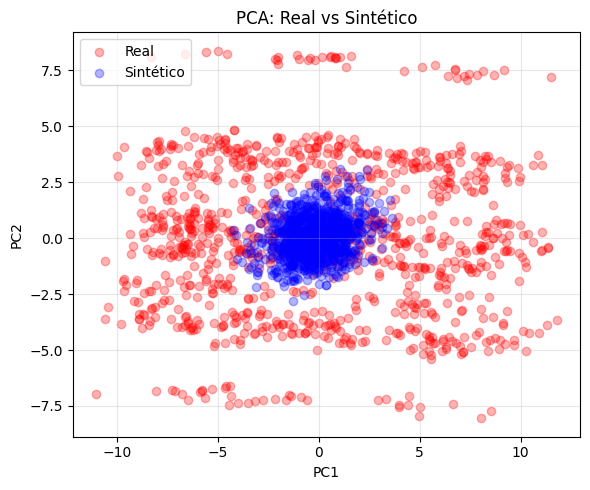

🌀 Ejecutando t-SNE (puede tardar unos segundos)...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.125s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.286701


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.292442
[t-SNE] KL divergence after 500 iterations: 1.974340


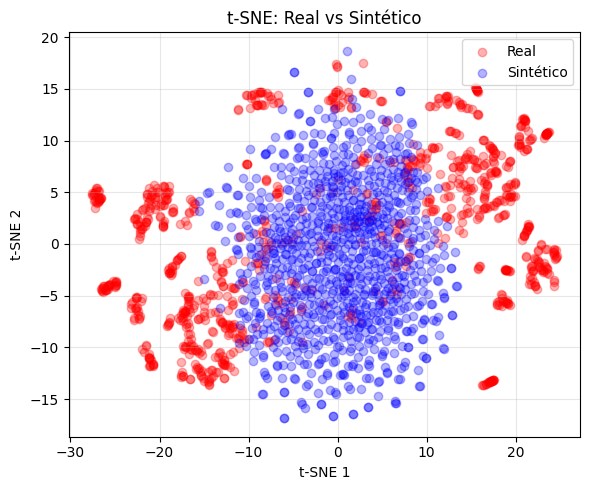

In [33]:
from generation_TGAN import safe_generation
import numpy as np

generated_data = safe_generation(model, num_samples=len(ori_data), batch_size=64)

n_vis = 50000  # target

n_real = min(n_vis, len(ori_data))
n_fake = min(n_vis, len(generated_data))

idx_real = np.random.choice(len(ori_data), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

ori_vis = [ori_data[i] for i in idx_real]
gen_vis = [generated_data[i] for i in idx_fake]

from visualization_TGAN import visualization

visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')

In [34]:
import numpy as np

syn_data = np.array(generated_data)   # datos sintéticos
real_data = np.array(ori_data)        # datos reales

# Aplanar correctamente: (N, seq_len, features)
# Calculamos medias y std por feature
real_mean = real_data.mean(axis=(0,1))
real_std  = real_data.std(axis=(0,1))

syn_mean  = syn_data.mean(axis=(0,1))
syn_std   = syn_data.std(axis=(0,1))

print("==== MEDIA POR FEATURE ====")
for i in range(len(real_mean)):
    print(f"Feature {i}: Real = {real_mean[i]:.4f}, Synthetic = {syn_mean[i]:.4f}")

print("\n==== STD POR FEATURE ====")
for i in range(len(real_std)):
    print(f"Feature {i}: Real = {real_std[i]:.4f}, Synthetic = {syn_std[i]:.4f}")


==== MEDIA POR FEATURE ====
Feature 0: Real = 0.5047, Synthetic = 0.5087
Feature 1: Real = 0.4585, Synthetic = 0.4591
Feature 2: Real = 0.4708, Synthetic = 0.4789
Feature 3: Real = 0.4982, Synthetic = 0.5065
Feature 4: Real = 0.5024, Synthetic = 0.5097
Feature 5: Real = 0.5642, Synthetic = 0.5624
Feature 6: Real = 0.4427, Synthetic = 0.4297

==== STD POR FEATURE ====
Feature 0: Real = 0.2008, Synthetic = 0.2001
Feature 1: Real = 0.1775, Synthetic = 0.1737
Feature 2: Real = 0.1453, Synthetic = 0.1455
Feature 3: Real = 0.2195, Synthetic = 0.2177
Feature 4: Real = 0.1735, Synthetic = 0.1691
Feature 5: Real = 0.1822, Synthetic = 0.1779
Feature 6: Real = 0.2921, Synthetic = 0.2861


In [35]:

from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# 1. Options
opt = Options().parse()


opt.print_freq = 100    # imprime cada iteración

# 2. Set paper-style hyperparameters
opt.lr_g = 5e-5     # LR para el generador
opt.lr_d = 1e-4    # LR para el discriminador
opt.lr_e = 1e-4     # encoder
opt.lr_r = 5e-4     # recovery
opt.lr_s = 2e-4     # supervisor


opt.beta1 = 0.5

opt.batch_size = 64
opt.iteration = 2000

opt.hidden_dim = 48   # muy importante
opt.num_layer = 2

opt.n_critic = 7     # OK
opt.gp_lambda = 10   # OK
opt.name = "TimeGAN_real_paper_settings"

opt.w_g    = 2.0   # antes 80
opt.w_e0   = 10.0   # antes 10
opt.w_es   = 0.5   # antes 0.1, lo dejamos en la misma escala
opt.w_gamma = 1.0  # este se puede mantener


# 3. Create model
model = TimeGAN(opt, ori_data)

# 4. Train
model.train()


[INFO] Auto-set z_dim = 7 (feature size from data)
=== PRETRAINING: Embedding + Recovery ===
[DEBUG] Loss this iteration: 0.111624
[ER] Iter 0/2000 | ER Loss = 0.111624
[DEBUG] Loss this iteration: 0.092944
[DEBUG] Loss this iteration: 0.074245
[DEBUG] Loss this iteration: 0.060725
[DEBUG] Loss this iteration: 0.056133
[DEBUG] Loss this iteration: 0.048395
[DEBUG] Loss this iteration: 0.046539
[DEBUG] Loss this iteration: 0.044905
[DEBUG] Loss this iteration: 0.039007
[DEBUG] Loss this iteration: 0.036552
[DEBUG] Loss this iteration: 0.036146
[DEBUG] Loss this iteration: 0.034626
[DEBUG] Loss this iteration: 0.032907
[DEBUG] Loss this iteration: 0.031410
[DEBUG] Loss this iteration: 0.031755
[DEBUG] Loss this iteration: 0.032564
[DEBUG] Loss this iteration: 0.028719
[DEBUG] Loss this iteration: 0.029625
[DEBUG] Loss this iteration: 0.028134
[DEBUG] Loss this iteration: 0.027071
[DEBUG] Loss this iteration: 0.028182
[DEBUG] Loss this iteration: 0.026195
[DEBUG] Loss this iteration: 0.02

🧩 Generating 50000 samples in 782 batches of 64...
  ✅ Batch 1/782 generated (64 samples)
  ✅ Batch 2/782 generated (64 samples)
  ✅ Batch 3/782 generated (64 samples)
  ✅ Batch 4/782 generated (64 samples)
  ✅ Batch 5/782 generated (64 samples)
  ✅ Batch 6/782 generated (64 samples)
  ✅ Batch 7/782 generated (64 samples)
  ✅ Batch 8/782 generated (64 samples)
  ✅ Batch 9/782 generated (64 samples)
  ✅ Batch 10/782 generated (64 samples)
  ✅ Batch 11/782 generated (64 samples)
  ✅ Batch 12/782 generated (64 samples)
  ✅ Batch 13/782 generated (64 samples)
  ✅ Batch 14/782 generated (64 samples)
  ✅ Batch 15/782 generated (64 samples)
  ✅ Batch 16/782 generated (64 samples)
  ✅ Batch 17/782 generated (64 samples)
  ✅ Batch 18/782 generated (64 samples)
  ✅ Batch 19/782 generated (64 samples)
  ✅ Batch 20/782 generated (64 samples)
  ✅ Batch 21/782 generated (64 samples)
  ✅ Batch 22/782 generated (64 samples)
  ✅ Batch 23/782 generated (64 samples)
  ✅ Batch 24/782 generated (64 samples

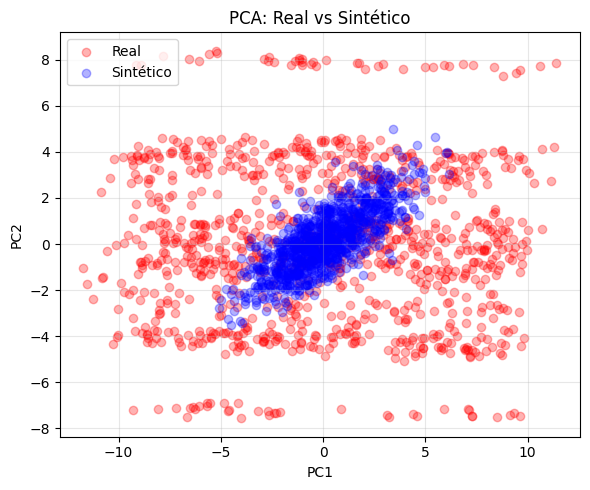

🌀 Ejecutando t-SNE (puede tardar unos segundos)...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.510401


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.880066
[t-SNE] KL divergence after 500 iterations: 1.747365


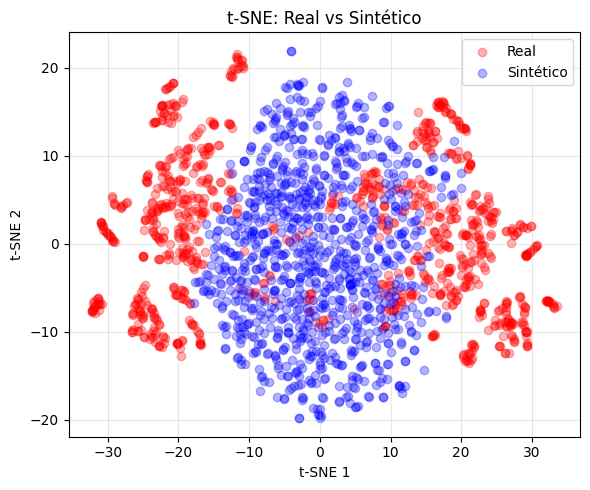

In [36]:
from generation_TGAN import safe_generation
import numpy as np

generated_data = safe_generation(model, num_samples=len(ori_data), batch_size=64)

n_vis = 50000  # target

n_real = min(n_vis, len(ori_data))
n_fake = min(n_vis, len(generated_data))

idx_real = np.random.choice(len(ori_data), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

ori_vis = [ori_data[i] for i in idx_real]
gen_vis = [generated_data[i] for i in idx_fake]

from visualization_TGAN import visualization

visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')

In [37]:
import numpy as np

syn_data = np.array(generated_data)   # datos sintéticos
real_data = np.array(ori_data)        # datos reales

# Aplanar correctamente: (N, seq_len, features)
# Calculamos medias y std por feature
real_mean = real_data.mean(axis=(0,1))
real_std  = real_data.std(axis=(0,1))

syn_mean  = syn_data.mean(axis=(0,1))
syn_std   = syn_data.std(axis=(0,1))

print("==== MEDIA POR FEATURE ====")
for i in range(len(real_mean)):
    print(f"Feature {i}: Real = {real_mean[i]:.4f}, Synthetic = {syn_mean[i]:.4f}")

print("\n==== STD POR FEATURE ====")
for i in range(len(real_std)):
    print(f"Feature {i}: Real = {real_std[i]:.4f}, Synthetic = {syn_std[i]:.4f}")


==== MEDIA POR FEATURE ====
Feature 0: Real = 0.5047, Synthetic = 0.5245
Feature 1: Real = 0.4585, Synthetic = 0.4777
Feature 2: Real = 0.4708, Synthetic = 0.4781
Feature 3: Real = 0.4982, Synthetic = 0.5202
Feature 4: Real = 0.5024, Synthetic = 0.5014
Feature 5: Real = 0.5642, Synthetic = 0.5918
Feature 6: Real = 0.4427, Synthetic = 0.4670

==== STD POR FEATURE ====
Feature 0: Real = 0.2008, Synthetic = 0.2005
Feature 1: Real = 0.1775, Synthetic = 0.1750
Feature 2: Real = 0.1453, Synthetic = 0.1444
Feature 3: Real = 0.2195, Synthetic = 0.2140
Feature 4: Real = 0.1735, Synthetic = 0.1625
Feature 5: Real = 0.1822, Synthetic = 0.1798
Feature 6: Real = 0.2921, Synthetic = 0.2812


In [38]:

from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# 1. Options
opt = Options().parse()


opt.print_freq = 100    # imprime cada iteración

# 2. Set paper-style hyperparameters
opt.lr_g = 5e-5     # LR para el generador
opt.lr_d = 1e-4    # LR para el discriminador
opt.lr_e = 1e-4     # encoder
opt.lr_r = 5e-4     # recovery
opt.lr_s = 2e-4     # supervisor


opt.beta1 = 0.5

opt.batch_size = 64
opt.iteration = 800

opt.hidden_dim = 48   # muy importante
opt.num_layer = 2

opt.n_critic = 5     # OK
opt.gp_lambda = 1   # OK
opt.name = "TimeGAN_real_paper_settings"

opt.w_g    = 1.0   # antes 80
opt.w_e0   = 5.0   # antes 10
opt.w_es   = 0.5   # antes 0.1, lo dejamos en la misma escala
opt.w_gamma = 1.0  # este se puede mantener


# 3. Create model
model = TimeGAN(opt, ori_data)

# 4. Train
model.train()


[INFO] Auto-set z_dim = 7 (feature size from data)
=== PRETRAINING: Embedding + Recovery ===
[DEBUG] Loss this iteration: 0.084228
[ER] Iter 0/800 | ER Loss = 0.084228
[DEBUG] Loss this iteration: 0.067563
[DEBUG] Loss this iteration: 0.063492
[DEBUG] Loss this iteration: 0.045504
[DEBUG] Loss this iteration: 0.043308
[DEBUG] Loss this iteration: 0.038908
[DEBUG] Loss this iteration: 0.035686
[DEBUG] Loss this iteration: 0.032796
[DEBUG] Loss this iteration: 0.031779
[DEBUG] Loss this iteration: 0.028656
[DEBUG] Loss this iteration: 0.028238
[DEBUG] Loss this iteration: 0.027532
[DEBUG] Loss this iteration: 0.025341
[DEBUG] Loss this iteration: 0.026260
[DEBUG] Loss this iteration: 0.022085
[DEBUG] Loss this iteration: 0.023386
[DEBUG] Loss this iteration: 0.019344
[DEBUG] Loss this iteration: 0.022232
[DEBUG] Loss this iteration: 0.021298
[DEBUG] Loss this iteration: 0.020138
[DEBUG] Loss this iteration: 0.020491
[DEBUG] Loss this iteration: 0.020073
[DEBUG] Loss this iteration: 0.018

🧩 Generating 50000 samples in 782 batches of 64...
  ✅ Batch 1/782 generated (64 samples)
  ✅ Batch 2/782 generated (64 samples)
  ✅ Batch 3/782 generated (64 samples)
  ✅ Batch 4/782 generated (64 samples)
  ✅ Batch 5/782 generated (64 samples)
  ✅ Batch 6/782 generated (64 samples)
  ✅ Batch 7/782 generated (64 samples)
  ✅ Batch 8/782 generated (64 samples)
  ✅ Batch 9/782 generated (64 samples)
  ✅ Batch 10/782 generated (64 samples)
  ✅ Batch 11/782 generated (64 samples)
  ✅ Batch 12/782 generated (64 samples)
  ✅ Batch 13/782 generated (64 samples)
  ✅ Batch 14/782 generated (64 samples)
  ✅ Batch 15/782 generated (64 samples)
  ✅ Batch 16/782 generated (64 samples)
  ✅ Batch 17/782 generated (64 samples)
  ✅ Batch 18/782 generated (64 samples)
  ✅ Batch 19/782 generated (64 samples)
  ✅ Batch 20/782 generated (64 samples)
  ✅ Batch 21/782 generated (64 samples)
  ✅ Batch 22/782 generated (64 samples)
  ✅ Batch 23/782 generated (64 samples)
  ✅ Batch 24/782 generated (64 samples

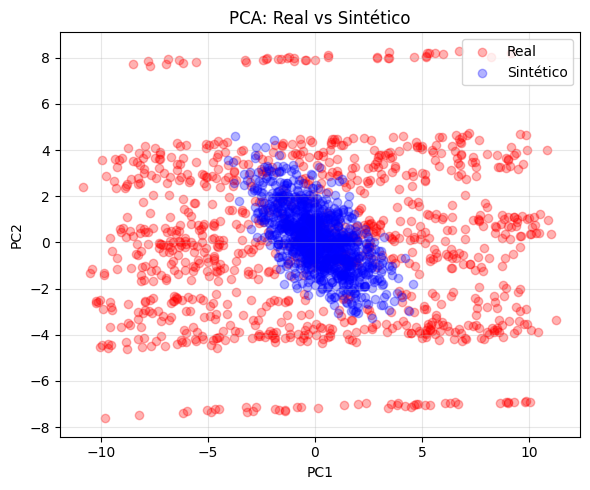

🌀 Ejecutando t-SNE (puede tardar unos segundos)...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.125s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.425377


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.330612
[t-SNE] KL divergence after 500 iterations: 1.770079


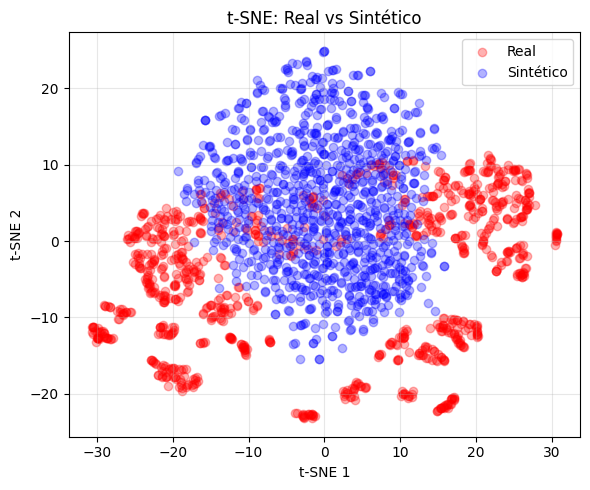

In [39]:
from generation_TGAN import safe_generation
import numpy as np

generated_data = safe_generation(model, num_samples=len(ori_data), batch_size=64)

n_vis = 50000  # target

n_real = min(n_vis, len(ori_data))
n_fake = min(n_vis, len(generated_data))

idx_real = np.random.choice(len(ori_data), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

ori_vis = [ori_data[i] for i in idx_real]
gen_vis = [generated_data[i] for i in idx_fake]

from visualization_TGAN import visualization

visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')

In [40]:
import numpy as np

syn_data = np.array(generated_data)   # datos sintéticos
real_data = np.array(ori_data)        # datos reales

# Aplanar correctamente: (N, seq_len, features)
# Calculamos medias y std por feature
real_mean = real_data.mean(axis=(0,1))
real_std  = real_data.std(axis=(0,1))

syn_mean  = syn_data.mean(axis=(0,1))
syn_std   = syn_data.std(axis=(0,1))

print("==== MEDIA POR FEATURE ====")
for i in range(len(real_mean)):
    print(f"Feature {i}: Real = {real_mean[i]:.4f}, Synthetic = {syn_mean[i]:.4f}")

print("\n==== STD POR FEATURE ====")
for i in range(len(real_std)):
    print(f"Feature {i}: Real = {real_std[i]:.4f}, Synthetic = {syn_std[i]:.4f}")


==== MEDIA POR FEATURE ====
Feature 0: Real = 0.5047, Synthetic = 0.4990
Feature 1: Real = 0.4585, Synthetic = 0.4782
Feature 2: Real = 0.4708, Synthetic = 0.4769
Feature 3: Real = 0.4982, Synthetic = 0.5126
Feature 4: Real = 0.5024, Synthetic = 0.5075
Feature 5: Real = 0.5642, Synthetic = 0.5737
Feature 6: Real = 0.4427, Synthetic = 0.4572

==== STD POR FEATURE ====
Feature 0: Real = 0.2008, Synthetic = 0.1969
Feature 1: Real = 0.1775, Synthetic = 0.1707
Feature 2: Real = 0.1453, Synthetic = 0.1436
Feature 3: Real = 0.2195, Synthetic = 0.2065
Feature 4: Real = 0.1735, Synthetic = 0.1649
Feature 5: Real = 0.1822, Synthetic = 0.1738
Feature 6: Real = 0.2921, Synthetic = 0.2468


CONDITIONAL IMPLEMENTATION

In [2]:
import h5py

data_file = r"C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat"

def short_explore(group, level=0, max_depth=2):
    indent = "  " * level
    for key in group.keys():
        try:
            obj = group[key]
            print(f"{indent}• {key}  ({type(obj).__name__})  shape={getattr(obj, 'shape', None)}")

            # Explore only first and second level
            if isinstance(obj, h5py.Group) and level < max_depth:
                short_explore(obj, level + 1, max_depth)
        except Exception as e:
            print(indent, "Error leyendo", key, ":", e)

with h5py.File(data_file, "r") as f:
    print("=== NIVEL 0 ===")
    short_explore(f)


=== NIVEL 0 ===
• #refs#  (Group)  shape=None
  • 0  (Group)  shape=None
    • meta  (Group)  shape=None
    • params  (Group)  shape=None
    • signals_processed  (Group)  shape=None
  • 0b  (Group)  shape=None
    • meta  (Group)  shape=None
    • params  (Group)  shape=None
    • signals_processed  (Group)  shape=None
  • 0c  (Group)  shape=None
    • meta  (Group)  shape=None
    • params  (Group)  shape=None
    • signals_processed  (Group)  shape=None
  • 1  (Group)  shape=None
    • meta  (Group)  shape=None
    • params  (Group)  shape=None
    • signals_processed  (Group)  shape=None
  • 1b  (Group)  shape=None
    • meta  (Group)  shape=None
    • params  (Group)  shape=None
    • signals_processed  (Group)  shape=None
  • 1c  (Group)  shape=None
    • meta  (Group)  shape=None
    • params  (Group)  shape=None
    • signals_processed  (Group)  shape=None
  • 2  (Group)  shape=None
    • meta  (Group)  shape=None
    • params  (Group)  shape=None
    • signals_processed  (Gro

In [3]:
import h5py

data_file = r"C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat"
f = h5py.File(data_file, 'r')

exp = f['#refs#']['0']

print("\n=== CAMPOS DE ESTE EXPERIMENTO ===")
print(list(exp.keys()))

print("\n=== CAMPOS DE meta ===")
print(list(exp['meta'].keys()))

print("\n=== CAMPOS DE params ===")
print(list(exp['params'].keys()))

print("\n=== CAMPOS DE signals_processed ===")
print(list(exp['signals_processed'].keys()))



=== CAMPOS DE ESTE EXPERIMENTO ===
['meta', 'params', 'signals_processed']

=== CAMPOS DE meta ===
['N_original', 'distance', 'file_name', 'fs_json', 'time_final', 'weight']

=== CAMPOS DE params ===
['Fs_target', 'f_cut', 'order']

=== CAMPOS DE signals_processed ===
['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']


In [4]:
import h5py

data_file = r"C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat"
f = h5py.File(data_file, 'r')

exp = f['#refs#']['0']

print("\n=== CAMPOS DE ESTE EXPERIMENTO ===")
print(list(exp.keys()))

print("\n=== CAMPOS DE meta ===")
print(list(exp['meta'].keys()))

print("\n=== CAMPOS DE params ===")
print(list(exp['params'].keys()))

print("\n=== CAMPOS DE signals_processed ===")
print(list(exp['signals_processed'].keys()))



=== CAMPOS DE ESTE EXPERIMENTO ===
['meta', 'params', 'signals_processed']

=== CAMPOS DE meta ===
['N_original', 'distance', 'file_name', 'fs_json', 'time_final', 'weight']

=== CAMPOS DE params ===
['Fs_target', 'f_cut', 'order']

=== CAMPOS DE signals_processed ===
['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']


In [5]:
from lib.data_preprocess import load_data

X_list, C_time_list, C_static_list, scalers, names = load_data(
    data_type="mytests",
    seq_len=256,
    file_list=["C:/Users/Dario/Desktop/ThesiS JBP/Data/all_signals_processed.mat"],
    step=256,          # ← EVITA SOLAPAMIENTO MASIVO
    max_sequences=5000 # ← Limita memoria
)

print(len(X_list), len(C_time_list), len(C_static_list))
print(X_list[0].shape)
print(C_time_list[0].shape)
print(C_static_list[0].shape)



📌 Loading: C:/Users/Dario/Desktop/ThesiS JBP/Data/all_signals_processed.mat
📌 Feature order: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
📌 Total sequences: 5000 | Each: 256×4
5000 5000 5000
(256, 4)
(256, 3)
(2,)


In [6]:
from options_TGAN import Options

# 1) Parsear opciones normalmente
opt = Options().parse()

# 2) Forzar modo condicional desde código
opt.conditional = True

# 3) Recalcular input_dim manualmente
opt.input_dim = opt.x_dim + opt.c_time_dim + opt.c_static_dim

print("conditional =", opt.conditional)
print("x_dim       =", opt.x_dim)
print("c_time_dim  =", opt.c_time_dim)
print("c_static_dim=", opt.c_static_dim)
print("input_dim   =", opt.input_dim)


conditional = True
x_dim       = 4
c_time_dim  = 3
c_static_dim= 2
input_dim   = 9


In [7]:
from options_TGAN import Options
from lib.TimeGAN import TimeGAN  # tu clase TimeGAN adaptada
from lib.data_preprocess import load_data

# 1) Opciones
opt = Options().parse()

# 2) Activar condicional
opt.conditional = True
opt.seq_len = 256
opt.x_dim = 4
opt.c_time_dim = 3
opt.c_static_dim = 2
opt.input_dim = opt.x_dim + opt.c_time_dim + opt.c_static_dim

print(">> input_dim =", opt.input_dim)

# 3) Cargar datos
X_list, C_time_list, C_static_list, scalers, names = load_data(
    data_type="mytests",
    seq_len=256,
    file_list=["C:/Users/Dario/Desktop/ThesiS JBP/Data/all_signals_processed.mat"],
    step=256,
    max_sequences=5000
)

print(len(X_list), X_list[0].shape)
print(len(C_time_list), C_time_list[0].shape)
print(len(C_static_list), C_static_list[0].shape)

# 4) Crear modelo condicional
model = TimeGAN(opt, X_list, C_time_list, C_static_list)
print("✅ Modelo creado en modo condicional.")


>> input_dim = 9
📌 Loading: C:/Users/Dario/Desktop/ThesiS JBP/Data/all_signals_processed.mat
📌 Feature order: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
📌 Total sequences: 5000 | Each: 256×4
5000 (256, 4)
5000 (256, 3)
5000 (2,)
[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32
✅ Modelo creado en modo condicional.


In [8]:
print("opt.conditional =", opt.conditional)

print(">>> ¿Qué detecta el TimeGAN internamente?")
print("model.conditional =", model.conditional)

print(">>> Tipos dentro del modelo BaseModel:")
print("type(model.C_time_all) =", type(model.C_time_all))
print("type(model.C_static_all) =", type(model.C_static_all))


opt.conditional = True
>>> ¿Qué detecta el TimeGAN internamente?
model.conditional = True
>>> Tipos dentro del modelo BaseModel:
type(model.C_time_all) = <class 'list'>
type(model.C_static_all) = <class 'list'>


In [9]:
print("opt.conditional =", opt.conditional)

print("\n>>> ¿Qué detecta el modelo internamente?")
print(" model.conditional =", model.conditional)

print("\n>>> Tipos guardados dentro del modelo:")
print(" type(model.X_all)        =", type(model.X_all))
print(" type(model.C_time_all)   =", type(model.C_time_all))
print(" type(model.C_static_all) =", type(model.C_static_all))

print("\n>>> Primeras formas:")
if model.C_time_all is not None:
    print(" C_time_all[0].shape   =", model.C_time_all[0].shape)
if model.C_static_all is not None:
    print(" C_static_all[0].shape =", model.C_static_all[0].shape)


opt.conditional = True

>>> ¿Qué detecta el modelo internamente?
 model.conditional = True

>>> Tipos guardados dentro del modelo:
 type(model.X_all)        = <class 'list'>
 type(model.C_time_all)   = <class 'list'>
 type(model.C_static_all) = <class 'list'>

>>> Primeras formas:
 C_time_all[0].shape   = (256, 3)
 C_static_all[0].shape = (2,)


In [10]:
from lib.data_preprocess import batch_generator_conditional

X_mb, C_time_mb, C_static_mb, T_mb = batch_generator_conditional(
    X_list, C_time_list, C_static_list, 
    model.ori_time,
    batch_size=opt.batch_size
)

print("X_mb:", X_mb.shape)
print("C_time_mb:", C_time_mb.shape)
print("C_static_mb:", C_static_mb.shape)
print("T_mb:", T_mb.shape)




X_mb: (128, 256, 4)
C_time_mb: (128, 256, 3)
C_static_mb: (128, 1, 2)
T_mb: (128,)


In [11]:
from lib.TimeGAN import TimeGAN  # tu clase TimeGAN adaptada
from options_TGAN import Options

from lib.data_preprocess import load_data

X_list, C_time_list, C_static_list, scalers, names = load_data(
    data_type="mytests",
    seq_len=256,
    file_list=["C:/Users/Dario/Desktop/ThesiS JBP/Data/all_signals_processed.mat"],
    step=256,
    max_sequences=5000
)
# 1) Opciones
opt = Options().parse()
opt.conditional = True        # ← OBLIGATORIO
opt.input_dim = opt.x_dim + opt.c_time_dim + opt.c_static_dim
model = TimeGAN(opt, X_list, C_time_list, C_static_list)

model.sample_batch()

print("X:", model.X.shape)
print("C_time:", model.C_time_mb.shape)
print("C_static:", model.C_static_mb.shape)
print("T:", model.T.shape)


📌 Loading: C:/Users/Dario/Desktop/ThesiS JBP/Data/all_signals_processed.mat
📌 Feature order: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
📌 Total sequences: 5000 | Each: 256×4
[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32

[SAMPLE_BATCH DEBUG]
  opt.conditional = True
  self.conditional = True
  type(X_all) = <class 'list'>
  type(C_time_all) = <class 'list'>
  type(C_static_all) = <class 'list'>
X: torch.Size([128, 256, 4])
C_time: torch.Size([128, 256, 3])
C_static: torch.Size([128, 1, 2])
T: (128,)


In [12]:
opt = Options().parse()

# Forzar condicional
opt.conditional = True
opt.input_dim = opt.x_dim + opt.c_time_dim + opt.c_static_dim

print(">>> BEFORE MODEL")
print(" opt.conditional =", opt.conditional)

# Crear modelo
model = TimeGAN(opt, X_list, C_time_list, C_static_list)

print("\n>>> AFTER MODEL")
print(" opt.conditional      =", model.opt.conditional)
print(" self.conditional     =", model.conditional)
print(" C_time_all is None?  =", (model.C_time_all is None))
print(" C_static_all is None =", (model.C_static_all is None))

# ahora test
model.sample_batch()

print("\n>>> sample_batch RESULTS")
print("X:", model.X.shape)
print("C_time_mb is None?   ", model.C_time_mb is None)
print("C_static_mb is None? ", model.C_static_mb is None)
print("T:", model.T.shape)


>>> BEFORE MODEL
 opt.conditional = True
[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32

>>> AFTER MODEL
 opt.conditional      = True
 self.conditional     = True
 C_time_all is None?  = False
 C_static_all is None = False

[SAMPLE_BATCH DEBUG]
  opt.conditional = True
  self.conditional = True
  type(X_all) = <class 'list'>
  type(C_time_all) = <class 'list'>
  type(C_static_all) = <class 'list'>

>>> sample_batch RESULTS
X: torch.Size([128, 256, 4])
C_time_mb is None?    False
C_static_mb is None?  False
T: (128,)


In [13]:
import numpy as np
from lib.data_preprocess import batch_generator_conditional

X_mb, C_time_mb, C_static_mb, T_mb = batch_generator_conditional(
    X_list,
    C_time_list,
    C_static_list,
    np.array([256]*len(X_list)),  # tiempos dummy
    8
)

print("X_mb:", type(X_mb), np.array(X_mb).shape)
print("C_time_mb:", type(C_time_mb))
print("C_static_mb:", type(C_static_mb))
print("T_mb:", type(T_mb))


X_mb: <class 'numpy.ndarray'> (8, 256, 4)
C_time_mb: <class 'numpy.ndarray'>
C_static_mb: <class 'numpy.ndarray'>
T_mb: <class 'numpy.ndarray'>


In [14]:
from options_TGAN import Options

opt = Options().parse()
opt.conditional = True   # ← ACTIVAMOS condicionamiento
opt.batch_size = 8       # pequeño para test
print("Conditional mode:", opt.conditional)


Conditional mode: True


In [15]:
from lib.data_preprocess import load_data

X_list, C_time_list, C_static_list, scalers, names = load_data(
    data_type="mytests",
    seq_len=256,
    step=256,                # evitar overlap
    max_sequences=2000,
    file_list=["C:/Users/Dario/Desktop/ThesiS JBP/Data/all_signals_processed.mat"]
)

print("X_list:", len(X_list), X_list[0].shape)
print("C_time_list:", len(C_time_list), C_time_list[0].shape)
print("C_static_list:", len(C_static_list), C_static_list[0].shape)


📌 Loading: C:/Users/Dario/Desktop/ThesiS JBP/Data/all_signals_processed.mat
📌 Feature order: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
📌 Total sequences: 2000 | Each: 256×4
X_list: 2000 (256, 4)
C_time_list: 2000 (256, 3)
C_static_list: 2000 (2,)


In [16]:
from lib.TimeGAN import TimeGAN

model = TimeGAN(opt, X_list, C_time_list, C_static_list)

print("Modelo creado exitosamente.")


[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32
Modelo creado exitosamente.


In [17]:
model.sample_batch()

print("X:", model.X.shape)
print("C_time:", model.C_time_mb.shape)
print("C_static:", model.C_static_mb.shape)
print("T:", model.T.shape)



[SAMPLE_BATCH DEBUG]
  opt.conditional = True
  self.conditional = True
  type(X_all) = <class 'list'>
  type(C_time_all) = <class 'list'>
  type(C_static_all) = <class 'list'>
X: torch.Size([8, 256, 4])
C_time: torch.Size([8, 256, 3])
C_static: torch.Size([8, 1, 2])
T: (8,)


In [18]:
model.sample_batch()
model.forward_e()
print(model.H.shape)




[SAMPLE_BATCH DEBUG]
  opt.conditional = True
  self.conditional = True
  type(X_all) = <class 'list'>
  type(C_time_all) = <class 'list'>
  type(C_static_all) = <class 'list'>
torch.Size([8, 256, 96])


In [19]:
import numpy as np
model.sample_batch()
model.Z = np.random.normal(0, 1, size=(opt.batch_size, opt.seq_len, opt.z_dim))

model.forward_g()

print("E_hat shape:", model.E_hat.shape)



[SAMPLE_BATCH DEBUG]
  opt.conditional = True
  self.conditional = True
  type(X_all) = <class 'list'>
  type(C_time_all) = <class 'list'>
  type(C_static_all) = <class 'list'>
E_hat shape: torch.Size([8, 256, 96])


In [30]:
model.Z = np.random.normal(0,1,(opt.batch_size,opt.seq_len,opt.z_dim))
d_loss = model.optimize_params_d()
print("D loss:", d_loss)










D loss: 61927.078125


TRAINING WITH CONITNUOUS CONDITIONAL TGAN

In [2]:
from lib.data_preprocess import load_data

data_file = r"C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat"
seq_len = 256

X_list, C_time_list, C_static_list, scalers, feature_names = load_data(
    data_type="mytests",
    seq_len=seq_len,
    file_list=[data_file],
    step=128,
    max_sequences=50000
)

print("N sequences:", len(X_list))
print("Example X shape:", X_list[0].shape)
print("Example C_time shape:", C_time_list[0].shape)
print("Example C_static shape:", C_static_list[0].shape)
print("Features:", feature_names)
print("N scalers:", len(scalers))


📌 Loading: C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat
📌 Feature order: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
📌 Total sequences: 50000 | Each: 256×4
N sequences: 50000
Example X shape: (256, 4)
Example C_time shape: (256, 3)
Example C_static shape: (2,)
Features: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
N scalers: 24


In [2]:
from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# ---------------------------------------
# 1. OPTIONS
# ---------------------------------------
opt = Options().parse()

# Activate CONDITIONAL MODE
opt.conditional = True

# Print frequency
opt.print_freq = 100

# ---------------------------------------
# 2. Hyperparameters (paper-style)
# ---------------------------------------
opt.lr_g = 5e-5      # Generator
opt.lr_d = 1e-4      # Discriminator
opt.lr_e = 1e-4      # Encoder
opt.lr_r = 5e-4      # Recovery
opt.lr_s = 2e-4      # Supervisor

opt.beta1 = 0.5

opt.batch_size = 64
opt.iteration = 500     # You will increase later to 3k–8k

opt.hidden_dim = 64
opt.num_layer = 2

opt.n_critic = 5
opt.gp_lambda = 1

opt.name = "TimeGAN_conditional_paper_settings"

# Loss weights
opt.w_g     = 1.0
opt.w_e0    = 5.0
opt.w_es    = 0.5
opt.w_gamma = 1.0


# ---------------------------------------
# 3. CREATE THE MODEL  (CONDITIONAL)
# ---------------------------------------
# Note: use the NEW data structure: X_list, C_time_list, C_static_list

model = TimeGAN(
    opt,
    X_list,        # your accelerometer sequences
    C_time_list,   # time-varying conditions (RPM, current, temp)
    C_static_list  # static conditions (weight, distance)
)

print("\n✅ Conditional TimeGAN initialized successfully\n")


# ---------------------------------------
# 4. TRAIN
# ---------------------------------------
model.train()


[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32

✅ Conditional TimeGAN initialized successfully

=== PRETRAINING: Embedding + Recovery ===
[ER] Iter 0/500 | ER Loss = 0.070522
[ER] Iter 100/500 | ER Loss = 0.013503
[ER] Iter 200/500 | ER Loss = 0.009979
[ER] Iter 300/500 | ER Loss = 0.007750
[ER] Iter 400/500 | ER Loss = 0.007620
[ER] Iter 499/500 | ER Loss = 0.006461
=== PRETRAINING: Supervisor ===
[S] Iter 0/500 | Supervisor Loss = 1.410150
[S] Iter 100/500 | Supervisor Loss = 0.401430
[S] Iter 200/500 | Supervisor Loss = 0.244131
[S] Iter 300/500 | Supervisor Loss = 0.187131
[S] Iter 400/500 | Supervisor Loss = 0.158188
[S] Iter 499/500 | Supervisor Loss = 0.140130
=== ADVERSARIAL TRAINING (WGAN-GP) ===
----------------------------------------------
[WGAN] Iter 0/500
  D Loss = 4196.087891
  G Loss = 1.957347
----------------------------------------------
----------------------------------------------
[WGAN] Iter 100/500
  D Loss = -7.918659

🧩 Generating 50000 samples in 782 batches of 64...
  ✅ Batch 1/782 generated (64 samples)
  ✅ Batch 2/782 generated (64 samples)
  ✅ Batch 3/782 generated (64 samples)
  ✅ Batch 4/782 generated (64 samples)
  ✅ Batch 5/782 generated (64 samples)
  ✅ Batch 6/782 generated (64 samples)
  ✅ Batch 7/782 generated (64 samples)
  ✅ Batch 8/782 generated (64 samples)
  ✅ Batch 9/782 generated (64 samples)
  ✅ Batch 10/782 generated (64 samples)
  ✅ Batch 11/782 generated (64 samples)
  ✅ Batch 12/782 generated (64 samples)
  ✅ Batch 13/782 generated (64 samples)
  ✅ Batch 14/782 generated (64 samples)
  ✅ Batch 15/782 generated (64 samples)
  ✅ Batch 16/782 generated (64 samples)
  ✅ Batch 17/782 generated (64 samples)
  ✅ Batch 18/782 generated (64 samples)
  ✅ Batch 19/782 generated (64 samples)
  ✅ Batch 20/782 generated (64 samples)
  ✅ Batch 21/782 generated (64 samples)
  ✅ Batch 22/782 generated (64 samples)
  ✅ Batch 23/782 generated (64 samples)
  ✅ Batch 24/782 generated (64 samples

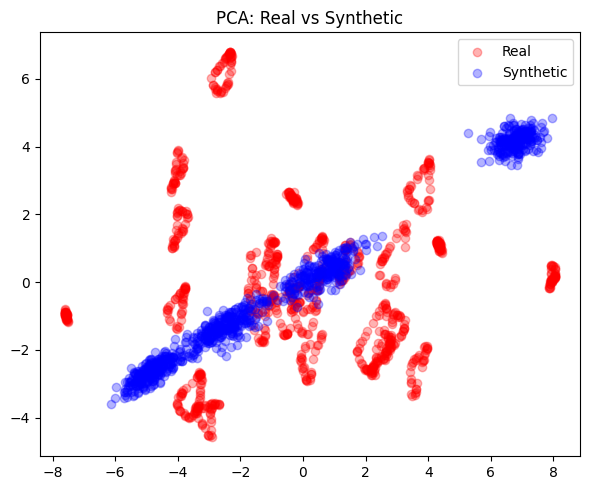

🌀 Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 2000 samples in 3.856s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.954714
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.708084
[t-SNE] KL divergence after 500 iterations: 0.973958


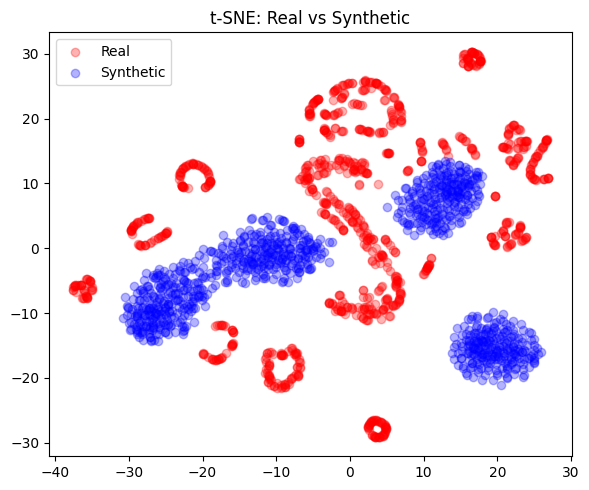

In [3]:
from generation_TGAN import safe_generation
import numpy as np

# Generate synthetic sequences
generated_data = safe_generation(
    model,
    num_samples=len(X_list),
    batch_size=64
)

# How many to visualize
n_vis = 50000
n_real = min(n_vis, len(X_list))
n_fake = min(n_vis, len(generated_data))

# Random indices
idx_real = np.random.choice(len(X_list), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

# Lists for visualization
ori_vis = [X_list[i] for i in idx_real]           # ← FIXED for conditional
gen_vis = [generated_data[i] for i in idx_fake]   # synthetic

# Visualizations
from visualization_TGAN import visualization
visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')


In [6]:
from evaluation_TGAN import evaluate_timegan

# Real sequences (256x4 accelerometer windows)
real_data = X_list     

# Synthetic sequences (generated after training)
syn_data = generated_data

# Evaluate
results = evaluate_timegan(real_data, syn_data, max_samples=2000)

print(results)



📊 [TimeGAN Evaluation Metrics]
-----------------------------------
         MSE: 0.053120
         MAE: 0.189422
        MAPE: 119.523392
        MSLE: 0.023245
          R2: -2.614934
   Mean_Corr: 0.000736
     KL_Mean: 0.464926
     KS_Mean: 0.000000

🔍 KS Test per Feature (p > 0.05 means similar distributions):
  Feature 0: p = 0.0000 ⚠️
  Feature 1: p = 0.0000 ⚠️
  Feature 2: p = 0.0000 ⚠️
  Feature 3: p = 0.0000 ⚠️
-----------------------------------

{'MSE': 0.05312015116214752, 'MAE': 0.1894223541021347, 'MAPE': 119.52339172363281, 'MSLE': 0.023245053365826607, 'R2': -2.6149344444274902, 'Mean_Corr': np.float32(0.00073569576), 'KL_Mean': np.float64(0.46492565443012773), 'KS_Mean': np.float64(0.0)}


In [9]:
from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# ---------------------------------------
# 1. OPTIONS
# ---------------------------------------
opt = Options().parse()

# Activate CONDITIONAL MODE
opt.conditional = True

# Print frequency
opt.print_freq = 100

# ---------------------------------------
# 2. Hyperparameters (paper-style)
# ---------------------------------------
opt.lr_g = 1e-4      # Generator
opt.lr_d = 5e-5      # Discriminator
opt.lr_e = 1e-4      # Encoder
opt.lr_r = 5e-4      # Recovery
opt.lr_s = 2e-4      # Supervisor

opt.beta1 = 0.5

opt.batch_size = 64
opt.iteration = 600     # You will increase later to 3k–8k

opt.hidden_dim = 128
opt.num_layer = 2

opt.n_critic = 5
opt.gp_lambda = 1

opt.name = "TimeGAN_conditional_paper_settings"

# Loss weights
opt.w_g     = 1.0
opt.w_e0    = 5.0
opt.w_es    = 0.5
opt.w_gamma = 1.0


# ---------------------------------------
# 3. CREATE THE MODEL  (CONDITIONAL)
# ---------------------------------------
# Note: use the NEW data structure: X_list, C_time_list, C_static_list

model = TimeGAN(
    opt,
    X_list,        # your accelerometer sequences
    C_time_list,   # time-varying conditions (RPM, current, temp)
    C_static_list  # static conditions (weight, distance)
)

print("\n✅ Conditional TimeGAN initialized successfully\n")


# ---------------------------------------
# 4. TRAIN
# ---------------------------------------
model.train()


[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32

✅ Conditional TimeGAN initialized successfully

=== PRETRAINING: Embedding + Recovery ===
[ER] Iter 0/600 | ER Loss = 0.111474
[ER] Iter 100/600 | ER Loss = 0.011702
[ER] Iter 200/600 | ER Loss = 0.009940
[ER] Iter 300/600 | ER Loss = 0.007223
[ER] Iter 400/600 | ER Loss = 0.007096
[ER] Iter 500/600 | ER Loss = 0.005811
[ER] Iter 599/600 | ER Loss = 0.005463
=== PRETRAINING: Supervisor ===
[S] Iter 0/600 | Supervisor Loss = 1.258972
[S] Iter 100/600 | Supervisor Loss = 0.297010
[S] Iter 200/600 | Supervisor Loss = 0.201087
[S] Iter 300/600 | Supervisor Loss = 0.166847
[S] Iter 400/600 | Supervisor Loss = 0.150977
[S] Iter 500/600 | Supervisor Loss = 0.141795
[S] Iter 599/600 | Supervisor Loss = 0.135401
=== ADVERSARIAL TRAINING (WGAN-GP) ===
----------------------------------------------
[WGAN] Iter 0/600
  D Loss = 4248.629883
  G Loss = 2.543676
----------------------------------------------
--

🧩 Generating 50000 samples in 782 batches of 64...
  ✅ Batch 1/782 generated (64 samples)
  ✅ Batch 2/782 generated (64 samples)
  ✅ Batch 3/782 generated (64 samples)
  ✅ Batch 4/782 generated (64 samples)
  ✅ Batch 5/782 generated (64 samples)
  ✅ Batch 6/782 generated (64 samples)
  ✅ Batch 7/782 generated (64 samples)
  ✅ Batch 8/782 generated (64 samples)
  ✅ Batch 9/782 generated (64 samples)
  ✅ Batch 10/782 generated (64 samples)
  ✅ Batch 11/782 generated (64 samples)
  ✅ Batch 12/782 generated (64 samples)
  ✅ Batch 13/782 generated (64 samples)
  ✅ Batch 14/782 generated (64 samples)
  ✅ Batch 15/782 generated (64 samples)
  ✅ Batch 16/782 generated (64 samples)
  ✅ Batch 17/782 generated (64 samples)
  ✅ Batch 18/782 generated (64 samples)
  ✅ Batch 19/782 generated (64 samples)
  ✅ Batch 20/782 generated (64 samples)
  ✅ Batch 21/782 generated (64 samples)
  ✅ Batch 22/782 generated (64 samples)
  ✅ Batch 23/782 generated (64 samples)
  ✅ Batch 24/782 generated (64 samples

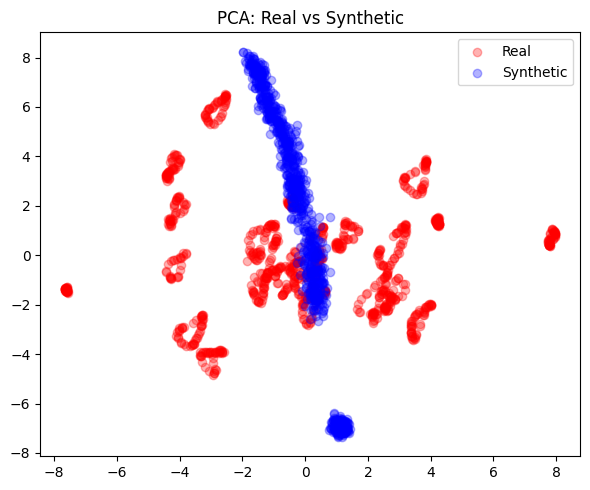

🌀 Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.637167


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.478729
[t-SNE] KL divergence after 500 iterations: 0.795237


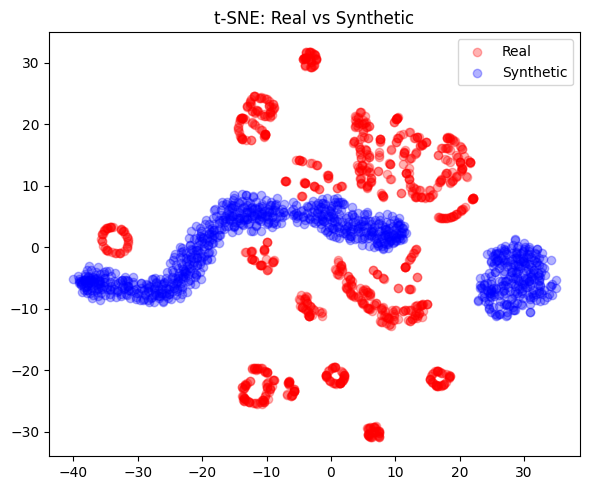

In [10]:
from generation_TGAN import safe_generation
import numpy as np

# Generate synthetic sequences
generated_data = safe_generation(
    model,
    num_samples=len(X_list),
    batch_size=64
)

# How many to visualize
n_vis = 50000
n_real = min(n_vis, len(X_list))
n_fake = min(n_vis, len(generated_data))

# Random indices
idx_real = np.random.choice(len(X_list), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

# Lists for visualization
ori_vis = [X_list[i] for i in idx_real]           # ← FIXED for conditional
gen_vis = [generated_data[i] for i in idx_fake]   # synthetic

# Visualizations
from visualization_TGAN import visualization
visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')


In [11]:
from evaluation_TGAN import evaluate_timegan

# Real sequences (256x4 accelerometer windows)
real_data = X_list     

# Synthetic sequences (generated after training)
syn_data = generated_data

# Evaluate
results = evaluate_timegan(real_data, syn_data, max_samples=2000)

print(results)



📊 [TimeGAN Evaluation Metrics]
-----------------------------------
         MSE: 0.050068
         MAE: 0.181714
        MAPE: 102.805717
        MSLE: 0.022741
          R2: -2.345767
   Mean_Corr: -0.001167
     KL_Mean: 0.302316
     KS_Mean: 0.000000

🔍 KS Test per Feature (p > 0.05 means similar distributions):
  Feature 0: p = 0.0000 ⚠️
  Feature 1: p = 0.0000 ⚠️
  Feature 2: p = 0.0000 ⚠️
  Feature 3: p = 0.0000 ⚠️
-----------------------------------

{'MSE': 0.05006823688745499, 'MAE': 0.18171381950378418, 'MAPE': 102.80571746826172, 'MSLE': 0.022741079330444336, 'R2': -2.345766544342041, 'Mean_Corr': np.float32(-0.0011672293), 'KL_Mean': np.float64(0.30231646896422165), 'KS_Mean': np.float64(0.0)}


In [ ]:
#PHASE 1 - STABILIZATION OF D LOSS AND G LOSS WIHTOUT COLLAPSE, CHECK KL NOT YET (PHASE 2)
from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# ---------------------------------------
# 1. OPTIONS
# ---------------------------------------
opt = Options().parse()

# Activate CONDITIONAL MODE
opt.conditional = True

# Print frequency
opt.print_freq = 100

# ---------------------------------------
# 2. Hyperparameters (paper-style)
# ---------------------------------------
opt.lr_g = 2e-4      # Generator
opt.lr_d = 1e-5      # Discriminator
opt.lr_e = 1e-4      # Encoder
opt.lr_r = 5e-4      # Recovery
opt.lr_s = 2e-4      # Supervisor

opt.beta1 = 0.5

opt.batch_size = 64
opt.iteration = 500     # You will increase later to 3k–8k

opt.hidden_dim = 64
opt.num_layer = 2

opt.n_critic = 1
opt.gp_lambda = 0.01

opt.name = "TimeGAN_conditional_paper_settings"

# Loss weights
opt.w_g     = 1.0
opt.w_e0    = 5.0
opt.w_es    = 0.5
opt.w_gamma = 1.0


# ---------------------------------------
# 3. CREATE THE MODEL  (CONDITIONAL)
# ---------------------------------------
# Note: use the NEW data structure: X_list, C_time_list, C_static_list

model = TimeGAN(
    opt,
    X_list,        # your accelerometer sequences
    C_time_list,   # time-varying conditions (RPM, current, temp)
    C_static_list  # static conditions (weight, distance)
)

print("\n✅ Conditional TimeGAN initialized successfully\n")


# ---------------------------------------
# 4. TRAIN
# ---------------------------------------
model.train()


[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32

✅ Conditional TimeGAN initialized successfully

=== PRETRAINING: Embedding + Recovery ===
[ER] Iter 0/500 | ER Loss = 0.121347
[ER] Iter 100/500 | ER Loss = 0.014102
[ER] Iter 200/500 | ER Loss = 0.009276
[ER] Iter 300/500 | ER Loss = 0.009071
[ER] Iter 400/500 | ER Loss = 0.007897
[ER] Iter 499/500 | ER Loss = 0.006952
=== PRETRAINING: Supervisor ===
[S] Iter 0/500 | Supervisor Loss = 1.372111
[S] Iter 100/500 | Supervisor Loss = 0.450690
[S] Iter 200/500 | Supervisor Loss = 0.270673
[S] Iter 300/500 | Supervisor Loss = 0.208504
[S] Iter 400/500 | Supervisor Loss = 0.178239
[S] Iter 499/500 | Supervisor Loss = 0.160636
=== ADVERSARIAL TRAINING (WGAN-GP) ===
----------------------------------------------
[WGAN] Iter 0/500
  D Loss = 45.184452
  G Loss = -0.732787
----------------------------------------------
----------------------------------------------
[WGAN] Iter 100/500
  D Loss = 22.065182


In [20]:
from evaluation_TGAN import evaluate_timegan

# Real sequences (256x4 accelerometer windows)
real_data = X_list     

# Synthetic sequences (generated after training)
syn_data = model.generated_data

# Evaluate
results = evaluate_timegan(real_data, syn_data, max_samples=2000)

print(results)



📊 [TimeGAN Evaluation Metrics]
-----------------------------------
         MSE: 0.035829
         MAE: 0.151469
        MAPE: 936.928589
        MSLE: 0.016220
          R2: -1.500280
   Mean_Corr: 0.005412
     KL_Mean: 0.235961
     KS_Mean: 0.000000

🔍 KS Test per Feature (p > 0.05 means similar distributions):
  Feature 0: p = 0.0000 ⚠️
  Feature 1: p = 0.0000 ⚠️
  Feature 2: p = 0.0000 ⚠️
  Feature 3: p = 0.0000 ⚠️
-----------------------------------

{'MSE': 0.03582930564880371, 'MAE': 0.15146906673908234, 'MAPE': 936.9285888671875, 'MSLE': 0.01622014120221138, 'R2': -1.5002801418304443, 'Mean_Corr': np.float32(0.0054119295), 'KL_Mean': np.float64(0.23596117905666486), 'KS_Mean': np.float64(2.591119216828433e-211)}


In [21]:
#PHASE 2 -
# target: stability, avoid collapse, decrease mse/mae, decrease KL divergence, controll D-G
from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# ---------------------------------------
# 1. OPTIONS
# ---------------------------------------
opt = Options().parse()

# Activate CONDITIONAL MODE
opt.conditional = True

# Print frequency
opt.print_freq = 100

# ---------------------------------------
# 2. Hyperparameters (paper-style)
# ---------------------------------------
opt.lr_g = 1e-4      # Generator
opt.lr_d = 1e-5      # Discriminator
opt.lr_e = 1e-4      # Encoder
opt.lr_r = 5e-4      # Recovery
opt.lr_s = 2e-4      # Supervisor

opt.beta1 = 0.5

opt.batch_size = 128
opt.iteration = 500     # You will increase later to 3k–8k

opt.hidden_dim = 128
opt.num_layer = 2

opt.n_critic = 2
opt.gp_lambda = 0.1

opt.name = "TimeGAN_conditional_paper_settings"

# Loss weights
opt.w_g     = 1.0
opt.w_e0    = 5.0
opt.w_es    = 0.5
opt.w_gamma = 1.0


# ---------------------------------------
# 3. CREATE THE MODEL  (CONDITIONAL)
# ---------------------------------------
# Note: use the NEW data structure: X_list, C_time_list, C_static_list

model = TimeGAN(
    opt,
    X_list,        # your accelerometer sequences
    C_time_list,   # time-varying conditions (RPM, current, temp)
    C_static_list  # static conditions (weight, distance)
)

print("\n✅ Conditional TimeGAN initialized successfully\n")


# ---------------------------------------
# 4. TRAIN
# ---------------------------------------
model.train()


[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32

✅ Conditional TimeGAN initialized successfully

=== PRETRAINING: Embedding + Recovery ===
[ER] Iter 0/500 | ER Loss = 0.111743
[ER] Iter 100/500 | ER Loss = 0.013530
[ER] Iter 200/500 | ER Loss = 0.008080
[ER] Iter 300/500 | ER Loss = 0.007002
[ER] Iter 400/500 | ER Loss = 0.005470
[ER] Iter 499/500 | ER Loss = 0.004898
=== PRETRAINING: Supervisor ===
[S] Iter 0/500 | Supervisor Loss = 1.398077
[S] Iter 100/500 | Supervisor Loss = 0.327489
[S] Iter 200/500 | Supervisor Loss = 0.236205
[S] Iter 300/500 | Supervisor Loss = 0.201200
[S] Iter 400/500 | Supervisor Loss = 0.191379
[S] Iter 499/500 | Supervisor Loss = 0.169781
=== ADVERSARIAL TRAINING (WGAN-GP) ===
----------------------------------------------
[WGAN] Iter 0/500
  D Loss = 468.328552
  G Loss = -1.168357
----------------------------------------------
----------------------------------------------
[WGAN] Iter 100/500
  D Loss = 66.373001

In [22]:
from evaluation_TGAN import evaluate_timegan

# Real sequences (256x4 accelerometer windows)
real_data = X_list     

# Synthetic sequences (generated after training)
syn_data = model.generated_data

# Evaluate
results = evaluate_timegan(real_data, syn_data, max_samples=2000)

print(results)



📊 [TimeGAN Evaluation Metrics]
-----------------------------------
         MSE: 0.026490
         MAE: 0.128352
        MAPE: 299.446533
        MSLE: 0.011815
          R2: -0.793953
   Mean_Corr: -0.003701
     KL_Mean: 0.282339
     KS_Mean: 0.000000

🔍 KS Test per Feature (p > 0.05 means similar distributions):
  Feature 0: p = 0.0000 ⚠️
  Feature 1: p = 0.0000 ⚠️
  Feature 2: p = 0.0000 ⚠️
  Feature 3: p = 0.0000 ⚠️
-----------------------------------

{'MSE': 0.026489753276109695, 'MAE': 0.1283522993326187, 'MAPE': 299.446533203125, 'MSLE': 0.011815275996923447, 'R2': -0.7939527034759521, 'Mean_Corr': np.float32(-0.003700565), 'KL_Mean': np.float64(0.28233858164325915), 'KS_Mean': np.float64(8.397438899256887e-309)}


In [ ]:
#Phase 3
#✔ reduce KL divergence below 0.20
#✔ improve distribution shape (KS test)
#✔ increase conditional fidelity
#✔ sharpen high-frequency details
#✔ generate more realistic accelerometer morphology

In [23]:
from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# ---------------------------------------
# 1. OPTIONS
# ---------------------------------------
opt = Options().parse()

# Activate CONDITIONAL MODE
opt.conditional = True

# Print frequency
opt.print_freq = 100

# ---------------------------------------
# 2. Hyperparameters (paper-style)
# ---------------------------------------
opt.lr_g = 1e-5      # Generator
opt.lr_d = 1e-5      # Discriminator
opt.lr_e = 1e-4      # Encoder
opt.lr_r = 5e-4      # Recovery
opt.lr_s = 2e-4      # Supervisor

opt.beta1 = 0.5

opt.batch_size = 128
opt.iteration = 800     # You will increase later to 3k–8k

opt.hidden_dim = 128
opt.num_layer = 2

opt.n_critic = 3
opt.gp_lambda = 0.2

opt.name = "TimeGAN_conditional_paper_settings"

# Loss weights
opt.w_g     = 1.0
opt.w_e0    = 5.0
opt.w_es    = 0.5
opt.w_gamma = 1.0


# ---------------------------------------
# 3. CREATE THE MODEL  (CONDITIONAL)
# ---------------------------------------
# Note: use the NEW data structure: X_list, C_time_list, C_static_list

model = TimeGAN(
    opt,
    X_list,        # your accelerometer sequences
    C_time_list,   # time-varying conditions (RPM, current, temp)
    C_static_list  # static conditions (weight, distance)
)

print("\n✅ Conditional TimeGAN initialized successfully\n")


# ---------------------------------------
# 4. TRAIN
# ---------------------------------------
model.train()


[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32

✅ Conditional TimeGAN initialized successfully

=== PRETRAINING: Embedding + Recovery ===
[ER] Iter 0/800 | ER Loss = 0.110456
[ER] Iter 100/800 | ER Loss = 0.012820
[ER] Iter 200/800 | ER Loss = 0.009738
[ER] Iter 300/800 | ER Loss = 0.007389
[ER] Iter 400/800 | ER Loss = 0.005755
[ER] Iter 500/800 | ER Loss = 0.005527
[ER] Iter 600/800 | ER Loss = 0.004580
[ER] Iter 700/800 | ER Loss = 0.004352
[ER] Iter 799/800 | ER Loss = 0.003406
=== PRETRAINING: Supervisor ===
[S] Iter 0/800 | Supervisor Loss = 1.265623
[S] Iter 100/800 | Supervisor Loss = 0.329466
[S] Iter 200/800 | Supervisor Loss = 0.241736
[S] Iter 300/800 | Supervisor Loss = 0.213277
[S] Iter 400/800 | Supervisor Loss = 0.185744
[S] Iter 500/800 | Supervisor Loss = 0.179050
[S] Iter 600/800 | Supervisor Loss = 0.176715
[S] Iter 700/800 | Supervisor Loss = 0.176012
[S] Iter 799/800 | Supervisor Loss = 0.160527
=== ADVERSARIAL TRAINING (

In [24]:
from evaluation_TGAN import evaluate_timegan

# Real sequences (256x4 accelerometer windows)
real_data = X_list     

# Synthetic sequences (generated after training)
syn_data = model.generated_data

# Evaluate
results = evaluate_timegan(real_data, syn_data, max_samples=2000)

print(results)



📊 [TimeGAN Evaluation Metrics]
-----------------------------------
         MSE: 0.034849
         MAE: 0.150389
        MAPE: 1042.868408
        MSLE: 0.015240
          R2: -1.407283
   Mean_Corr: -0.000118
     KL_Mean: 0.439636
     KS_Mean: 0.000000

🔍 KS Test per Feature (p > 0.05 means similar distributions):
  Feature 0: p = 0.0000 ⚠️
  Feature 1: p = 0.0000 ⚠️
  Feature 2: p = 0.0000 ⚠️
  Feature 3: p = 0.0000 ⚠️
-----------------------------------

{'MSE': 0.0348486565053463, 'MAE': 0.150388702750206, 'MAPE': 1042.868408203125, 'MSLE': 0.015240257605910301, 'R2': -1.407282829284668, 'Mean_Corr': np.float32(-0.0001178761), 'KL_Mean': np.float64(0.4396361655968708), 'KS_Mean': np.float64(0.0)}


In [25]:
from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# ---------------------------------------
# 1. OPTIONS
# ---------------------------------------
opt = Options().parse()

# Activate CONDITIONAL MODE
opt.conditional = True

# Print frequency
opt.print_freq = 100

# ---------------------------------------
# 2. Hyperparameters (paper-style)
# ---------------------------------------
opt.lr_g = 8e-5      # Generator
opt.lr_d = 5e-5      # Discriminator
opt.lr_e = 1e-4      # Encoder
opt.lr_r = 5e-4      # Recovery
opt.lr_s = 2e-4      # Supervisor

opt.beta1 = 0.5

opt.batch_size = 128
opt.iteration = 800     # You will increase later to 3k–8k

opt.hidden_dim = 128
opt.num_layer = 2

opt.n_critic = 3
opt.gp_lambda = 0.2

opt.name = "TimeGAN_conditional_paper_settings"

# Loss weights
opt.w_g     = 1.0
opt.w_e0    = 5.0
opt.w_es    = 0.5
opt.w_gamma = 1.0


# ---------------------------------------
# 3. CREATE THE MODEL  (CONDITIONAL)
# ---------------------------------------
# Note: use the NEW data structure: X_list, C_time_list, C_static_list

model = TimeGAN(
    opt,
    X_list,        # your accelerometer sequences
    C_time_list,   # time-varying conditions (RPM, current, temp)
    C_static_list  # static conditions (weight, distance)
)

print("\n✅ Conditional TimeGAN initialized successfully\n")


# ---------------------------------------
# 4. TRAIN
# ---------------------------------------
model.train()


[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32

✅ Conditional TimeGAN initialized successfully

=== PRETRAINING: Embedding + Recovery ===
[ER] Iter 0/800 | ER Loss = 0.076454
[ER] Iter 100/800 | ER Loss = 0.013911
[ER] Iter 200/800 | ER Loss = 0.008113
[ER] Iter 300/800 | ER Loss = 0.007956
[ER] Iter 400/800 | ER Loss = 0.006554
[ER] Iter 500/800 | ER Loss = 0.004827
[ER] Iter 600/800 | ER Loss = 0.004188
[ER] Iter 700/800 | ER Loss = 0.003550
[ER] Iter 799/800 | ER Loss = 0.003146
=== PRETRAINING: Supervisor ===
[S] Iter 0/800 | Supervisor Loss = 1.301141
[S] Iter 100/800 | Supervisor Loss = 0.327733
[S] Iter 200/800 | Supervisor Loss = 0.226023
[S] Iter 300/800 | Supervisor Loss = 0.196128
[S] Iter 400/800 | Supervisor Loss = 0.168523
[S] Iter 500/800 | Supervisor Loss = 0.156424
[S] Iter 600/800 | Supervisor Loss = 0.152638
[S] Iter 700/800 | Supervisor Loss = 0.157380
[S] Iter 799/800 | Supervisor Loss = 0.145354
=== ADVERSARIAL TRAINING (

In [26]:
from evaluation_TGAN import evaluate_timegan

# Real sequences (256x4 accelerometer windows)
real_data = X_list     

# Synthetic sequences (generated after training)
syn_data = model.generated_data

# Evaluate
results = evaluate_timegan(real_data, syn_data, max_samples=2000)

print(results)



📊 [TimeGAN Evaluation Metrics]
-----------------------------------
         MSE: 0.052511
         MAE: 0.187815
        MAPE: 619.166321
        MSLE: 0.023802
          R2: -2.623889
   Mean_Corr: -0.006576
     KL_Mean: 0.372349
     KS_Mean: 0.000000

🔍 KS Test per Feature (p > 0.05 means similar distributions):
  Feature 0: p = 0.0000 ⚠️
  Feature 1: p = 0.0000 ⚠️
  Feature 2: p = 0.0000 ⚠️
  Feature 3: p = 0.0000 ⚠️
-----------------------------------

{'MSE': 0.05251055955886841, 'MAE': 0.18781468272209167, 'MAPE': 619.1663208007812, 'MSLE': 0.02380231022834778, 'R2': -2.6238889694213867, 'Mean_Corr': np.float32(-0.0065763034), 'KL_Mean': np.float64(0.372349333117037), 'KS_Mean': np.float64(4.962054012820583e-308)}


In [27]:
from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# ---------------------------------------
# 1. OPTIONS
# ---------------------------------------
opt = Options().parse()

# Activate CONDITIONAL MODE
opt.conditional = True

# Print frequency
opt.print_freq = 100

# ---------------------------------------
# 2. Hyperparameters (paper-style)
# ---------------------------------------
opt.lr_g = 5e-5      # Generator
opt.lr_d = 1.5e-5      # Discriminator
opt.lr_e = 1e-4      # Encoder
opt.lr_r = 5e-4      # Recovery
opt.lr_s = 2e-4      # Supervisor

opt.beta1 = 0.5

opt.batch_size = 128
opt.iteration = 800     # You will increase later to 3k–8k

opt.hidden_dim = 128
opt.num_layer = 2

opt.n_critic = 3
opt.gp_lambda = 0.2

opt.name = "TimeGAN_conditional_paper_settings"

# Loss weights
opt.w_g     = 1.0
opt.w_e0    = 5.0
opt.w_es    = 0.5
opt.w_gamma = 1.0


# ---------------------------------------
# 3. CREATE THE MODEL  (CONDITIONAL)
# ---------------------------------------
# Note: use the NEW data structure: X_list, C_time_list, C_static_list

model = TimeGAN(
    opt,
    X_list,        # your accelerometer sequences
    C_time_list,   # time-varying conditions (RPM, current, temp)
    C_static_list  # static conditions (weight, distance)
)

print("\n✅ Conditional TimeGAN initialized successfully\n")


# ---------------------------------------
# 4. TRAIN
# ---------------------------------------
model.train()


[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32

✅ Conditional TimeGAN initialized successfully

=== PRETRAINING: Embedding + Recovery ===
[ER] Iter 0/800 | ER Loss = 0.072644
[ER] Iter 100/800 | ER Loss = 0.016951
[ER] Iter 200/800 | ER Loss = 0.009502
[ER] Iter 300/800 | ER Loss = 0.011155
[ER] Iter 400/800 | ER Loss = 0.006374
[ER] Iter 500/800 | ER Loss = 0.005797
[ER] Iter 600/800 | ER Loss = 0.005068
[ER] Iter 700/800 | ER Loss = 0.004022
[ER] Iter 799/800 | ER Loss = 0.003609
=== PRETRAINING: Supervisor ===
[S] Iter 0/800 | Supervisor Loss = 1.283409
[S] Iter 100/800 | Supervisor Loss = 0.318329
[S] Iter 200/800 | Supervisor Loss = 0.241729
[S] Iter 300/800 | Supervisor Loss = 0.205241
[S] Iter 400/800 | Supervisor Loss = 0.188033
[S] Iter 500/800 | Supervisor Loss = 0.180885
[S] Iter 600/800 | Supervisor Loss = 0.173717
[S] Iter 700/800 | Supervisor Loss = 0.162189
[S] Iter 799/800 | Supervisor Loss = 0.167626
=== ADVERSARIAL TRAINING (

In [28]:
from evaluation_TGAN import evaluate_timegan

# Real sequences (256x4 accelerometer windows)
real_data = X_list     

# Synthetic sequences (generated after training)
syn_data = model.generated_data

# Evaluate
results = evaluate_timegan(real_data, syn_data, max_samples=2000)

print(results)



📊 [TimeGAN Evaluation Metrics]
-----------------------------------
         MSE: 0.038984
         MAE: 0.159706
        MAPE: 793.743225
        MSLE: 0.017433
          R2: -1.675701
   Mean_Corr: 0.001120
     KL_Mean: 0.339213
     KS_Mean: 0.000000

🔍 KS Test per Feature (p > 0.05 means similar distributions):
  Feature 0: p = 0.0000 ⚠️
  Feature 1: p = 0.0000 ⚠️
  Feature 2: p = 0.0000 ⚠️
  Feature 3: p = 0.0000 ⚠️
-----------------------------------

{'MSE': 0.03898351266980171, 'MAE': 0.1597059667110443, 'MAPE': 793.7432250976562, 'MSLE': 0.017433492466807365, 'R2': -1.6757014989852905, 'Mean_Corr': np.float32(0.0011197677), 'KL_Mean': np.float64(0.3392127724688762), 'KS_Mean': np.float64(0.0)}


BASE LINE CONDITIONAL TIMEGAN

In [3]:
from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# ---------------------------------------
# 1. OPTIONS
# ---------------------------------------
opt = Options().parse()

# Activate CONDITIONAL MODE
opt.conditional = True

# Print frequency
opt.print_freq = 100

# ---------------------------------------
# 2. Hyperparameters (paper-style)
# ---------------------------------------
opt.lr_g = 6.5e-5      # Generator
opt.lr_d = 1.5e-5      # Discriminator
opt.lr_e = 1e-4      # Encoder
opt.lr_r = 5e-4      # Recovery
opt.lr_s = 2e-4      # Supervisor

opt.beta1 = 0.5

opt.batch_size = 128
opt.iteration = 800     # You will increase later to 3k–8k

opt.hidden_dim = 128
opt.num_layer = 2

opt.n_critic = 3
opt.gp_lambda = 0.2

opt.name = "TimeGAN_conditional_paper_settings"

# Loss weights
opt.w_g     = 1.0
opt.w_e0    = 5.0
opt.w_es    = 0.5
opt.w_gamma = 1.0


# ---------------------------------------
# 3. CREATE THE MODEL  (CONDITIONAL)
# ---------------------------------------
# Note: use the NEW data structure: X_list, C_time_list, C_static_list

model = TimeGAN(
    opt,
    X_list,        # your accelerometer sequences
    C_time_list,   # time-varying conditions (RPM, current, temp)
    C_static_list  # static conditions (weight, distance)
)

print("\n✅ Conditional TimeGAN initialized successfully\n")


# ---------------------------------------
# 4. TRAIN
# ---------------------------------------
model.train()


[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32

✅ Conditional TimeGAN initialized successfully

=== PRETRAINING: Embedding + Recovery ===
[ER] Iter 0/800 | ER Loss = 0.095666
[ER] Iter 100/800 | ER Loss = 0.010193
[ER] Iter 200/800 | ER Loss = 0.008442
[ER] Iter 300/800 | ER Loss = 0.005861
[ER] Iter 400/800 | ER Loss = 0.005286
[ER] Iter 500/800 | ER Loss = 0.004408
[ER] Iter 600/800 | ER Loss = 0.003787
[ER] Iter 700/800 | ER Loss = 0.003485
[ER] Iter 799/800 | ER Loss = 0.002779
=== PRETRAINING: Supervisor ===
[S] Iter 0/800 | Supervisor Loss = 1.337718
[S] Iter 100/800 | Supervisor Loss = 0.333368
[S] Iter 200/800 | Supervisor Loss = 0.246347
[S] Iter 300/800 | Supervisor Loss = 0.207542
[S] Iter 400/800 | Supervisor Loss = 0.187722
[S] Iter 500/800 | Supervisor Loss = 0.174697
[S] Iter 600/800 | Supervisor Loss = 0.176951
[S] Iter 700/800 | Supervisor Loss = 0.168347
[S] Iter 799/800 | Supervisor Loss = 0.166541
=== ADVERSARIAL TRAINING (

In [5]:
from evaluation_TGAN import evaluate_timegan

# Real sequences (256x4 accelerometer windows)
real_data = X_list     

# Synthetic sequences (generated after training)
syn_data = model.generated_data

# Evaluate
results = evaluate_timegan(real_data, syn_data, max_samples=2000)

print(results)



📊 [TimeGAN Evaluation Metrics]
-----------------------------------
         MSE: 0.023697
         MAE: 0.123261
        MAPE: 331.555359
        MSLE: 0.010323
          R2: -0.588404
   Mean_Corr: -0.000818
     KL_Mean: 0.333827
     KS_Mean: 0.000000

🔍 KS Test per Feature (p > 0.05 means similar distributions):
  Feature 0: p = 0.0000 ⚠️
  Feature 1: p = 0.0000 ⚠️
  Feature 2: p = 0.0000 ⚠️
  Feature 3: p = 0.0000 ⚠️
-----------------------------------

{'MSE': 0.02369673363864422, 'MAE': 0.12326128035783768, 'MAPE': 331.55535888671875, 'MSLE': 0.01032296009361744, 'R2': -0.5884037017822266, 'Mean_Corr': np.float32(-0.00081835524), 'KL_Mean': np.float64(0.33382679161835316), 'KS_Mean': np.float64(0.0)}


🧩 Generating 50000 samples in 782 batches of 64...
  ✅ Batch 1/782 generated (64 samples)
  ✅ Batch 2/782 generated (64 samples)
  ✅ Batch 3/782 generated (64 samples)
  ✅ Batch 4/782 generated (64 samples)
  ✅ Batch 5/782 generated (64 samples)
  ✅ Batch 6/782 generated (64 samples)
  ✅ Batch 7/782 generated (64 samples)
  ✅ Batch 8/782 generated (64 samples)
  ✅ Batch 9/782 generated (64 samples)
  ✅ Batch 10/782 generated (64 samples)
  ✅ Batch 11/782 generated (64 samples)
  ✅ Batch 12/782 generated (64 samples)
  ✅ Batch 13/782 generated (64 samples)
  ✅ Batch 14/782 generated (64 samples)
  ✅ Batch 15/782 generated (64 samples)
  ✅ Batch 16/782 generated (64 samples)
  ✅ Batch 17/782 generated (64 samples)
  ✅ Batch 18/782 generated (64 samples)
  ✅ Batch 19/782 generated (64 samples)
  ✅ Batch 20/782 generated (64 samples)
  ✅ Batch 21/782 generated (64 samples)
  ✅ Batch 22/782 generated (64 samples)
  ✅ Batch 23/782 generated (64 samples)
  ✅ Batch 24/782 generated (64 samples

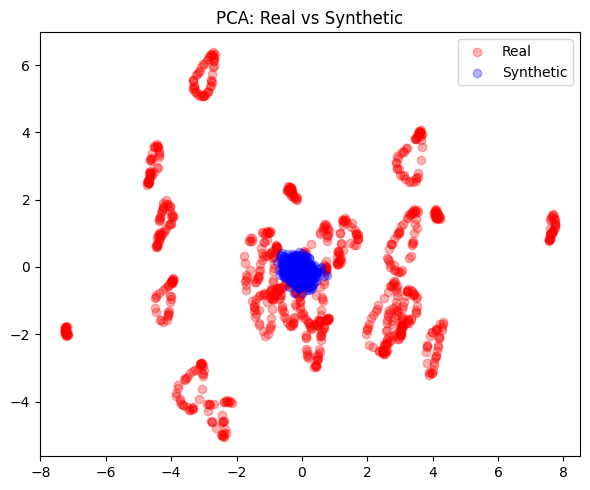

🌀 Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 2000 samples in 4.347s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.451257
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.949593
[t-SNE] KL divergence after 500 iterations: 1.497293


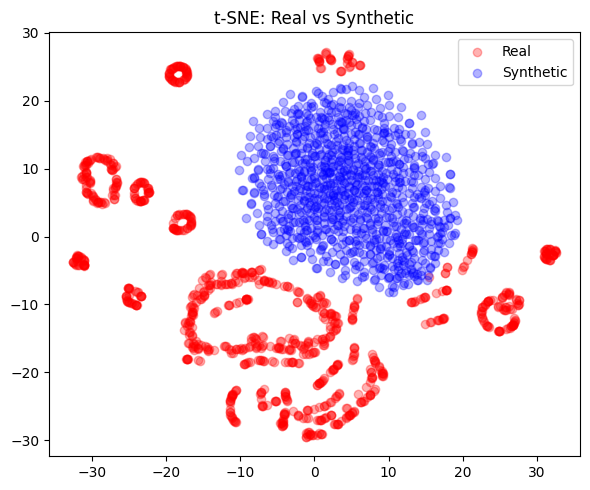

In [6]:
from generation_TGAN import safe_generation
import numpy as np

# Generate synthetic sequences
generated_data = safe_generation(
    model,
    num_samples=len(X_list),
    batch_size=64
)

# How many to visualize
n_vis = 50000
n_real = min(n_vis, len(X_list))
n_fake = min(n_vis, len(generated_data))

# Random indices
idx_real = np.random.choice(len(X_list), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

# Lists for visualization
ori_vis = [X_list[i] for i in idx_real]           # ← FIXED for conditional
gen_vis = [generated_data[i] for i in idx_fake]   # synthetic

# Visualizations
from visualization_TGAN import visualization
visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')


RPM mean min: 3.544893e-05
RPM mean max: 0.9999562


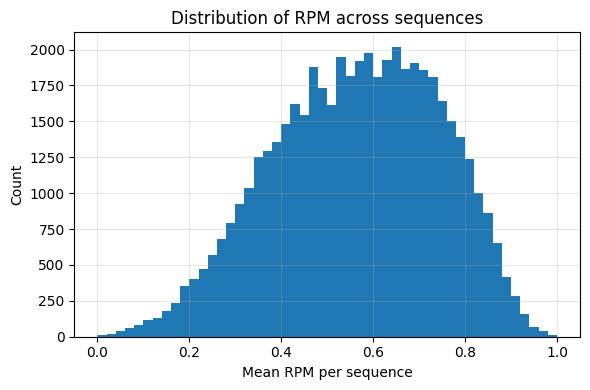

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Mean RPM por secuencia
rpm_means = np.array([c[:, 1].mean() for c in C_time_list])  # canal 1 = Speed/RPM

print("RPM mean min:", rpm_means.min())
print("RPM mean max:", rpm_means.max())

plt.figure(figsize=(6,4))
plt.hist(rpm_means, bins=50)
plt.xlabel("Mean RPM per sequence")
plt.ylabel("Count")
plt.title("Distribution of RPM across sequences")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [16]:
target_center = 0.45
band = 0.05

low = target_center - band
high = target_center + band

mask = (rpm_means >= low) & (rpm_means <= high)
idx_sel = np.where(mask)[0]

print("Selected sequences:", len(idx_sel))


Selected sequences: 8267


RPM NORMALIZED range: 3.544893e-05 → 0.9999562


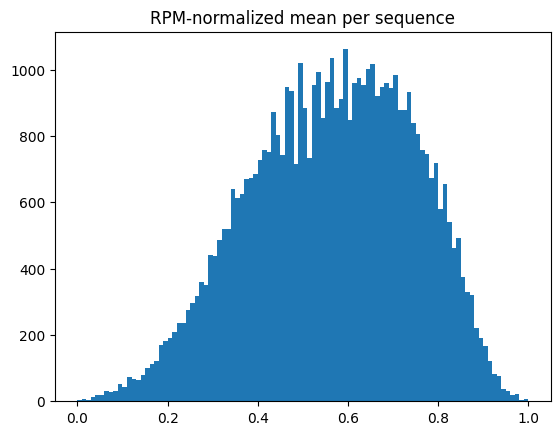

In [17]:
rpm_per_seq = np.array([c[:,1] for c in C_time_list])
rpm_means = rpm_per_seq.mean(axis=1)

print("RPM NORMALIZED range:", rpm_means.min(), "→", rpm_means.max())

plt.hist(rpm_means, bins=100)
plt.title("RPM-normalized mean per sequence")
plt.show()


In [18]:
from generation_conditional import generate_batch_from_conditions
synthetic_filtered = generate_batch_from_conditions(
    model,
    C_time_list,
    C_static_list,
    idx_sel
)

print("Synthetic sequences generated:", len(synthetic_filtered))



Synthetic sequences generated: 8267


In [19]:
real_filtered = [X_list[i] for i in idx_sel]

real_flat = np.array([seq.reshape(-1) for seq in real_filtered])
syn_flat  = np.array([seq.reshape(-1) for seq in synthetic_filtered])

print(real_flat.shape, syn_flat.shape)


(8267, 1024) (8267, 1024)


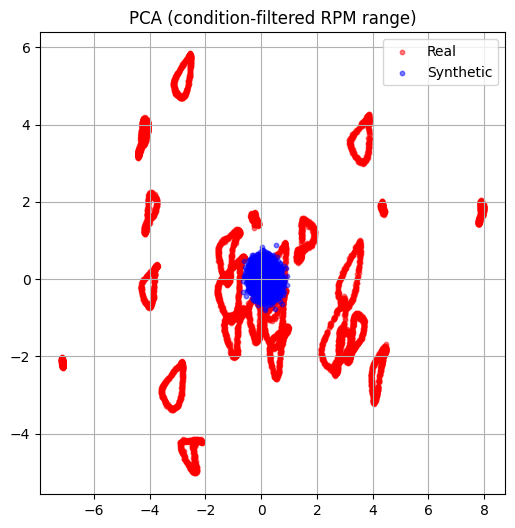

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_real = pca.fit_transform(real_flat)
pca_syn  = pca.transform(syn_flat)

plt.figure(figsize=(6,6))
plt.scatter(pca_real[:,0], pca_real[:,1], s=10, c="red", alpha=0.5, label="Real")
plt.scatter(pca_syn[:,0],  pca_syn[:,1],  s=10, c="blue", alpha=0.5, label="Synthetic")
plt.legend()
plt.title("PCA (condition-filtered RPM range)")
plt.grid()
plt.show()


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


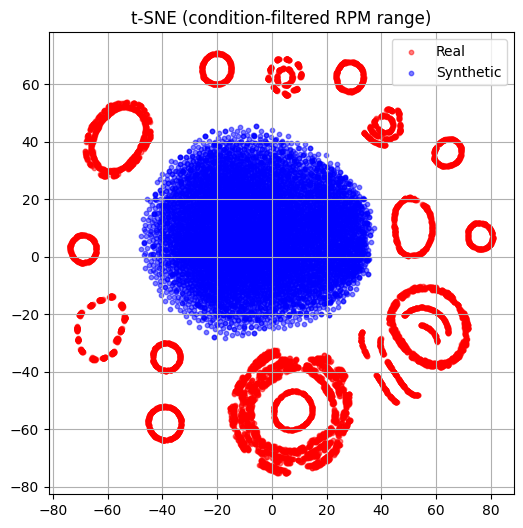

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, learning_rate=200, n_iter=1000)
tsne_embedded = tsne.fit_transform(np.vstack([real_flat, syn_flat]))

tsne_real = tsne_embedded[:len(real_flat)]
tsne_syn  = tsne_embedded[len(real_flat):]

plt.figure(figsize=(6,6))
plt.scatter(tsne_real[:,0], tsne_real[:,1], s=10, c="red", alpha=0.5, label="Real")
plt.scatter(tsne_syn[:,0],  tsne_syn[:,1],  s=10, c="blue", alpha=0.5, label="Synthetic")
plt.legend()
plt.title("t-SNE (condition-filtered RPM range)")
plt.grid()
plt.show()


In [22]:
#Here we check if changing the iterations the model improve or not.
from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# ---------------------------------------
# 1. OPTIONS
# ---------------------------------------
opt = Options().parse()

# Activate CONDITIONAL MODE
opt.conditional = True

# Print frequency
opt.print_freq = 100

# ---------------------------------------
# 2. Hyperparameters (paper-style)
# ---------------------------------------
opt.lr_g = 6.5e-5      # Generator
opt.lr_d = 1.5e-5      # Discriminator
opt.lr_e = 1e-4      # Encoder
opt.lr_r = 5e-4      # Recovery
opt.lr_s = 2e-4      # Supervisor

opt.beta1 = 0.5

opt.batch_size = 128
opt.iteration = 2500     # You will increase later to 3k–8k

opt.hidden_dim = 128
opt.num_layer = 2

opt.n_critic = 3
opt.gp_lambda = 0.2

opt.name = "TimeGAN_conditional_paper_settings"

# Loss weights
opt.w_g     = 1.0
opt.w_e0    = 5.0
opt.w_es    = 0.5
opt.w_gamma = 1.0


# ---------------------------------------
# 3. CREATE THE MODEL  (CONDITIONAL)
# ---------------------------------------
# Note: use the NEW data structure: X_list, C_time_list, C_static_list

model = TimeGAN(
    opt,
    X_list,        # your accelerometer sequences
    C_time_list,   # time-varying conditions (RPM, current, temp)
    C_static_list  # static conditions (weight, distance)
)

print("\n✅ Conditional TimeGAN initialized successfully\n")


# ---------------------------------------
# 4. TRAIN
# ---------------------------------------
model.train()


[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32

✅ Conditional TimeGAN initialized successfully

=== PRETRAINING: Embedding + Recovery ===
[ER] Iter 0/2500 | ER Loss = 0.150985
[ER] Iter 100/2500 | ER Loss = 0.009492
[ER] Iter 200/2500 | ER Loss = 0.009749
[ER] Iter 300/2500 | ER Loss = 0.006937
[ER] Iter 400/2500 | ER Loss = 0.005049
[ER] Iter 500/2500 | ER Loss = 0.004257
[ER] Iter 600/2500 | ER Loss = 0.003849
[ER] Iter 700/2500 | ER Loss = 0.003119
[ER] Iter 800/2500 | ER Loss = 0.003017
[ER] Iter 900/2500 | ER Loss = 0.002441
[ER] Iter 1000/2500 | ER Loss = 0.002449
[ER] Iter 1100/2500 | ER Loss = 0.001959
[ER] Iter 1200/2500 | ER Loss = 0.001817
[ER] Iter 1300/2500 | ER Loss = 0.001709
[ER] Iter 1400/2500 | ER Loss = 0.001915
[ER] Iter 1500/2500 | ER Loss = 0.001520
[ER] Iter 1600/2500 | ER Loss = 0.001435
[ER] Iter 1700/2500 | ER Loss = 0.001291
[ER] Iter 1800/2500 | ER Loss = 0.001316
[ER] Iter 1900/2500 | ER Loss = 0.001190
[ER] Iter 2

In [23]:
from evaluation_TGAN import evaluate_timegan

# Real sequences (256x4 accelerometer windows)
real_data = X_list     

# Synthetic sequences (generated after training)
syn_data = model.generated_data

# Evaluate
results = evaluate_timegan(real_data, syn_data, max_samples=2000)

print(results)



📊 [TimeGAN Evaluation Metrics]
-----------------------------------
         MSE: 0.044989
         MAE: 0.169232
        MAPE: 326.641815
        MSLE: 0.020718
          R2: -2.135103
   Mean_Corr: 0.008871
     KL_Mean: 0.205732
     KS_Mean: 0.000000

🔍 KS Test per Feature (p > 0.05 means similar distributions):
  Feature 0: p = 0.0000 ⚠️
  Feature 1: p = 0.0000 ⚠️
  Feature 2: p = 0.0000 ⚠️
  Feature 3: p = 0.0000 ⚠️
-----------------------------------

{'MSE': 0.04498917981982231, 'MAE': 0.1692315936088562, 'MAPE': 326.6418151855469, 'MSLE': 0.020717564970254898, 'R2': -2.1351029872894287, 'Mean_Corr': np.float32(0.0088707255), 'KL_Mean': np.float64(0.20573180648621608), 'KS_Mean': np.float64(0.0)}


🧩 Generating 50000 samples in 782 batches of 64...
  ✅ Batch 1/782 generated (64 samples)
  ✅ Batch 2/782 generated (64 samples)
  ✅ Batch 3/782 generated (64 samples)
  ✅ Batch 4/782 generated (64 samples)
  ✅ Batch 5/782 generated (64 samples)
  ✅ Batch 6/782 generated (64 samples)
  ✅ Batch 7/782 generated (64 samples)
  ✅ Batch 8/782 generated (64 samples)
  ✅ Batch 9/782 generated (64 samples)
  ✅ Batch 10/782 generated (64 samples)
  ✅ Batch 11/782 generated (64 samples)
  ✅ Batch 12/782 generated (64 samples)
  ✅ Batch 13/782 generated (64 samples)
  ✅ Batch 14/782 generated (64 samples)
  ✅ Batch 15/782 generated (64 samples)
  ✅ Batch 16/782 generated (64 samples)
  ✅ Batch 17/782 generated (64 samples)
  ✅ Batch 18/782 generated (64 samples)
  ✅ Batch 19/782 generated (64 samples)
  ✅ Batch 20/782 generated (64 samples)
  ✅ Batch 21/782 generated (64 samples)
  ✅ Batch 22/782 generated (64 samples)
  ✅ Batch 23/782 generated (64 samples)
  ✅ Batch 24/782 generated (64 samples

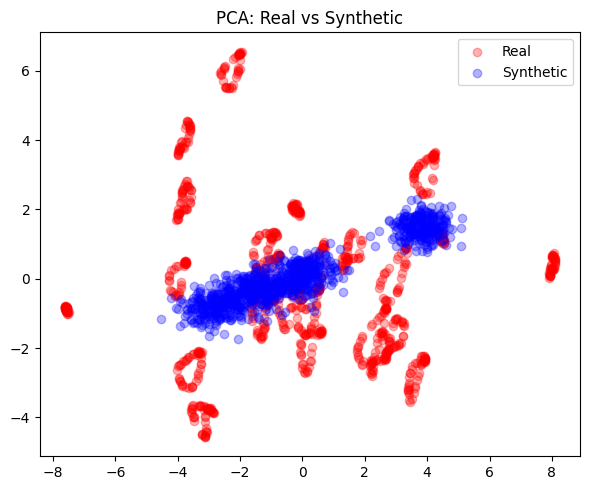

🌀 Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.342790


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.913853
[t-SNE] KL divergence after 500 iterations: 1.130440


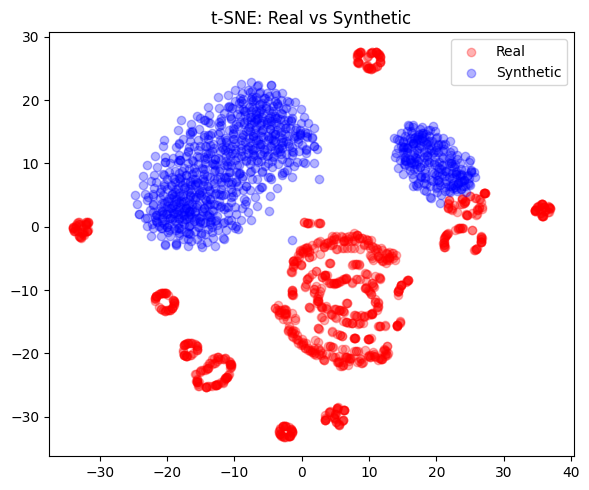

In [24]:
from generation_TGAN import safe_generation
import numpy as np

# Generate synthetic sequences
generated_data = safe_generation(
    model,
    num_samples=len(X_list),
    batch_size=64
)

# How many to visualize
n_vis = 50000
n_real = min(n_vis, len(X_list))
n_fake = min(n_vis, len(generated_data))

# Random indices
idx_real = np.random.choice(len(X_list), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

# Lists for visualization
ori_vis = [X_list[i] for i in idx_real]           # ← FIXED for conditional
gen_vis = [generated_data[i] for i in idx_fake]   # synthetic

# Visualizations
from visualization_TGAN import visualization
visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')


Here we adde the conditional to the discriminator also.

In [25]:
from lib.data_preprocess import load_data

data_file = r"C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat"
seq_len = 256

X_list, C_time_list, C_static_list, scalers, feature_names = load_data(
    data_type="mytests",
    seq_len=seq_len,
    file_list=[data_file],
    step=128,
    max_sequences=50000
)

print("N sequences:", len(X_list))
print("Example X shape:", X_list[0].shape)
print("Example C_time shape:", C_time_list[0].shape)
print("Example C_static shape:", C_static_list[0].shape)
print("Features:", feature_names)
print("N scalers:", len(scalers))


📌 Loading: C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat
📌 Feature order: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
📌 Total sequences: 50000 | Each: 256×4
N sequences: 50000
Example X shape: (256, 4)
Example C_time shape: (256, 3)
Example C_static shape: (2,)
Features: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
N scalers: 24


In [ ]:
from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# ---------------------------------------
# 1. OPTIONS
# ---------------------------------------
opt = Options().parse()

# Activate CONDITIONAL MODE
opt.conditional = True

# Print frequency
opt.print_freq = 100

# ---------------------------------------
# 2. Hyperparameters (paper-style)
# ---------------------------------------
opt.lr_g = 6.5e-5      # Generator
opt.lr_d = 1.5e-5      # Discriminator
opt.lr_e = 1e-4      # Encoder
opt.lr_r = 5e-4      # Recovery
opt.lr_s = 2e-4      # Supervisor

opt.beta1 = 0.5

opt.batch_size = 128
opt.iteration = 1500     # You will increase later to 3k–8k

opt.hidden_dim = 128
opt.num_layer = 2

opt.n_critic = 3
opt.gp_lambda = 0.2

opt.name = "TimeGAN_conditional_paper_settings"

# Loss weights
opt.w_g     = 1.0
opt.w_e0    = 5.0
opt.w_es    = 0.5
opt.w_gamma = 1.0


# ---------------------------------------
# 3. CREATE THE MODEL  (CONDITIONAL)
# ---------------------------------------
# Note: use the NEW data structure: X_list, C_time_list, C_static_list

model = TimeGAN(
    opt,
    X_list,        # your accelerometer sequences
    C_time_list,   # time-varying conditions (RPM, current, temp)
    C_static_list  # static conditions (weight, distance)
)

print("\n✅ Conditional TimeGAN initialized successfully\n")


# ---------------------------------------
# 4. TRAIN
# ---------------------------------------
model.train()


[INFO] Detected data feature dim (x_dim) = 4
[INFO] Using latent noise dim (z_dim)   = 32

✅ Conditional TimeGAN initialized successfully

=== PRETRAINING: Embedding + Recovery ===
[ER] Iter 0/1500 | ER Loss = 0.096344
[ER] Iter 100/1500 | ER Loss = 0.011904
[ER] Iter 200/1500 | ER Loss = 0.009036
[ER] Iter 300/1500 | ER Loss = 0.006034
[ER] Iter 400/1500 | ER Loss = 0.007811
[ER] Iter 500/1500 | ER Loss = 0.004582
[ER] Iter 600/1500 | ER Loss = 0.004496
[ER] Iter 700/1500 | ER Loss = 0.003512
[ER] Iter 800/1500 | ER Loss = 0.003187
[ER] Iter 900/1500 | ER Loss = 0.002715
[ER] Iter 1000/1500 | ER Loss = 0.002362
[ER] Iter 1100/1500 | ER Loss = 0.002172
[ER] Iter 1200/1500 | ER Loss = 0.001891
[ER] Iter 1300/1500 | ER Loss = 0.001900
[ER] Iter 1400/1500 | ER Loss = 0.001760
[ER] Iter 1499/1500 | ER Loss = 0.001709
=== PRETRAINING: Supervisor ===
[S] Iter 0/1500 | Supervisor Loss = 1.391718
[S] Iter 100/1500 | Supervisor Loss = 0.300277
[S] Iter 200/1500 | Supervisor Loss = 0.201796
[S] 